In [1]:
##DDPG

In [3]:
#utils.py

'''
Created on Aug 18, 2016

@author: rbhat
'''
import warnings

from keras.models import model_from_config, Sequential, Model
import keras.optimizers as optimizers


def clone_model(model, custom_objects={}):
    if len(custom_objects) > 0:
        warnings.warn('Due to an API problem with Keras, custom_objects is currently ignored. Sorry about that.')
    config = model.get_config()
    try:
        # TODO: re-enable custom_objects
        clone = Sequential.from_config(config)
    except:
        # TODO: re-enable custom_objects
        clone = Model.from_config(config)
    clone.set_weights(model.get_weights())
    return clone


def clone_optimizer(optimizer):
    params = dict([(k, v) for k, v in optimizer.get_config().items()])
    name = params.pop('name')
    clone = optimizers.get(name, params)
    if hasattr(optimizer, 'clipnorm'):
        clone.clipnorm = optimizer.clipnorm
    if hasattr(optimizer, 'clipvalue'):
        clone.clipvalue = optimizer.clipvalue
    return clone


def get_soft_target_model_updates(target, source, tau):
    target_weights = target.trainable_weights + sum([l.non_trainable_weights for l in target.layers], [])
    source_weights = source.trainable_weights + sum([l.non_trainable_weights for l in source.layers], [])
    assert len(target_weights) == len(source_weights)

    # Create updates.
    updates = []
    for tw, sw in zip(target_weights, source_weights):
        updates.append((tw, tau * sw + (1. - tau) * tw))
    return updates


class AdditionalUpdatesOptimizer(optimizers.Optimizer):
    def __init__(self, optimizer, additional_updates):
        super(AdditionalUpdatesOptimizer, self).__init__()
        self.optimizer = optimizer
        self.additional_updates = additional_updates

    def get_updates(self, params, constraints, loss):
        updates = self.optimizer.get_updates(params, constraints, loss)
        updates += self.additional_updates
        self.updates = updates
        return self.updates

    def get_config(self):
        return self.optimizer.get_config()

In [4]:
#Random Noise
'''
Created on Aug 18, 2016

@author: rbhat
'''
from __future__ import division
import numpy as np


class AnnealedGaussianProcess(object):
    def __init__(self, mu, sigma, sigma_min, n_steps_annealing):
        self.mu = mu
        self.sigma = sigma
        self.n_steps = 0

        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0.
            self.c = sigma
            self.sigma_min = sigma

    @property
    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.n_steps) + self.c)
        return sigma


class GaussianWhiteNoiseProcess(AnnealedGaussianProcess):
    def __init__(self, mu=0., sigma=1., sigma_min=None, n_steps_annealing=1000, size=1):
        super(GaussianWhiteNoiseProcess, self).__init__(mu=mu, sigma=sigma, sigma_min=sigma_min, n_steps_annealing=n_steps_annealing)
        self.size = size

    def sample(self):
        sample = np.random.normal(self.mu, self.current_sigma, self.size)
        self.n_steps += 1
        return sample

# Based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckProcess(AnnealedGaussianProcess):
    def __init__(self, theta, mu=0., sigma=1., dt=1e-2, x0=None, size=1, sigma_min=None, n_steps_annealing=1000):
        super(OrnsteinUhlenbeckProcess, self).__init__(mu=mu, sigma=sigma, sigma_min=sigma_min, n_steps_annealing=n_steps_annealing)
        self.theta = theta
        self.mu = mu
        self.dt = dt
        self.x_prev = x0 if x0 is not None else np.zeros(size)
        self.size = size

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.current_sigma * np.sqrt(self.dt) * np.random.normal(size=self.size)
        self.x_prev = x
        self.n_steps += 1
        return x

In [6]:
##Callbacks.py
'''
Created on Aug 18, 2016

@author: rbhat
'''
from __future__ import division
from __future__ import print_function
import warnings
import timeit
import json
from tempfile import mkdtemp

import numpy as np

from keras.callbacks import Callback as KerasCallback, CallbackList as KerasCallbackList
from keras.utils.generic_utils import Progbar


class Callback(KerasCallback):
    def _set_env(self, env):
        self.env = env

    def on_episode_begin(self, episode, logs={}):
        pass

    def on_episode_end(self, episode, logs={}):
        pass

    def on_step_begin(self, step, logs={}):
        pass

    def on_step_end(self, step, logs={}):
        pass

    def on_action_begin(self, action, logs={}):
        pass

    def on_action_end(self, action, logs={}):
        pass


class CallbackList(KerasCallbackList):
    def _set_env(self, env):
        for callback in self.callbacks:
            if callable(getattr(callback, '_set_env', None)):
                callback._set_env(env)

    def on_episode_begin(self, episode, logs={}):
        for callback in self.callbacks:
            # Check if callback supports the more appropriate `on_episode_begin` callback.
            # If not, fall back to `on_epoch_begin` to be compatible with built-in Keras callbacks.
            if callable(getattr(callback, 'on_episode_begin', None)):
                callback.on_episode_begin(episode, logs=logs)
            else:
                callback.on_epoch_begin(episode, logs=logs)

    def on_episode_end(self, episode, logs={}):
        for callback in self.callbacks:
            # Check if callback supports the more appropriate `on_episode_end` callback.
            # If not, fall back to `on_epoch_end` to be compatible with built-in Keras callbacks.
            if callable(getattr(callback, 'on_episode_end', None)):
                callback.on_episode_end(episode, logs=logs)
            else:
                callback.on_epoch_end(episode, logs=logs)

    def on_step_begin(self, step, logs={}):
        for callback in self.callbacks:
            # Check if callback supports the more appropriate `on_step_begin` callback.
            # If not, fall back to `on_batch_begin` to be compatible with built-in Keras callbacks.
            if callable(getattr(callback, 'on_step_begin', None)):
                callback.on_step_begin(step, logs=logs)
            else:
                callback.on_batch_begin(step, logs=logs)

    def on_step_end(self, step, logs={}):
        for callback in self.callbacks:
            # Check if callback supports the more appropriate `on_step_end` callback.
            # If not, fall back to `on_batch_end` to be compatible with built-in Keras callbacks.
            if callable(getattr(callback, 'on_step_end', None)):
                callback.on_step_end(step, logs=logs)
            else:
                callback.on_batch_end(step, logs=logs)

    def on_action_begin(self, action, logs={}):
        for callback in self.callbacks:
            if callable(getattr(callback, 'on_action_begin', None)):
                callback.on_action_begin(action, logs=logs)

    def on_action_end(self, action, logs={}):
        for callback in self.callbacks:
            if callable(getattr(callback, 'on_action_end', None)):
                callback.on_action_end(action, logs=logs)


class TestLogger(Callback):
    def on_episode_end(self, episode, logs):
        template = 'Episode {0}: reward: {1:.3f}, steps: {2}'
        variables = [
            episode + 1,
            logs['episode_reward'],
            logs['nb_steps'],
        ]
        print(template.format(*variables))


class TrainEpisodeLogger(Callback):
    def __init__(self):
        # Some algorithms compute multiple episodes at once since they are multi-threaded.
        # We therefore use a dictionary that is indexed by the episode to separate episodes
        # from each other.
        self.episode_start = {}
        self.observations = {}
        self.rewards = {}
        self.actions = {}
        self.metrics = {}
        self.step = 0

    def on_train_begin(self, logs):
        self.train_start = timeit.default_timer()
        self.metrics_names = self.model.metrics_names
        print('Training for {} steps ...'.format(self.params['nb_steps']))
        
    def on_train_end(self, logs):
        duration = timeit.default_timer() - self.train_start
        print('done, took {:.3f} seconds'.format(duration))

    def on_episode_begin(self, episode, logs):
        self.episode_start[episode] = timeit.default_timer()
        self.observations[episode] = []
        self.rewards[episode] = []
        self.actions[episode] = []
        self.metrics[episode] = []

    def on_episode_end(self, episode, logs):
        duration = timeit.default_timer() - self.episode_start[episode]
        episode_steps = len(self.observations[episode])

        # Format all metrics.
        metrics = np.array(self.metrics[episode])
        metrics_template = ''
        metrics_variables = []
        with warnings.catch_warnings():
            warnings.filterwarnings('error')
            for idx, name in enumerate(self.metrics_names):
                if idx > 0:
                    metrics_template += ', '
                try:
                    value = np.nanmean(metrics[:, idx])
                    metrics_template += '{}: {:f}'
                except Warning:
                    value = '--'
                    metrics_template += '{}: {}'
                metrics_variables += [name, value]          
        metrics_text = metrics_template.format(*metrics_variables)

        nb_step_digits = str(int(np.ceil(np.log10(self.params['nb_steps']))) + 1)
        template = '{step: ' + nb_step_digits + 'd}/{nb_steps}: episode: {episode}, duration: {duration:.3f}s, episode steps: {episode_steps}, steps per second: {sps:.0f}, episode reward: {episode_reward:.3f}, mean reward: {reward_mean:.3f} [{reward_min:.3f}, {reward_max:.3f}], mean action: {action_mean:.3f} [{action_min:.3f}, {action_max:.3f}], mean observation: {obs_mean:.3f} [{obs_min:.3f}, {obs_max:.3f}], {metrics}'
        variables = {
            'step': self.step,
            'nb_steps': self.params['nb_steps'],
            'episode': episode + 1,
            'duration': duration,
            'episode_steps': episode_steps,
            'sps': float(episode_steps) / duration,
            'episode_reward': np.sum(self.rewards[episode]),
            'reward_mean': np.mean(self.rewards[episode]),
            'reward_min': np.min(self.rewards[episode]),
            'reward_max': np.max(self.rewards[episode]),
            'action_mean': np.mean(self.actions[episode]),
            'action_min': np.min(self.actions[episode]),
            'action_max': np.max(self.actions[episode]),
            'obs_mean': np.mean(self.observations[episode]),
            'obs_min': np.min(self.observations[episode]),
            'obs_max': np.max(self.observations[episode]),
            'metrics': metrics_text,
        }
        print(template.format(**variables))

        # Free up resources.
        del self.episode_start[episode]
        del self.observations[episode]
        del self.rewards[episode]
        del self.actions[episode]
        del self.metrics[episode]

    def on_step_end(self, step, logs):
        episode = logs['episode']
        self.observations[episode].append(logs['observation'])
        self.rewards[episode].append(logs['reward'])
        self.actions[episode].append(logs['action'])
        self.metrics[episode].append(logs['metrics'])
        self.step += 1


class TrainIntervalLogger(Callback):
    def __init__(self, interval=10000):
        self.interval = interval
        self.step = 0
        self.reset()

    def reset(self):
        self.interval_start = timeit.default_timer()
        self.progbar = Progbar(target=self.interval)
        self.metrics = []

    def on_train_begin(self, logs):
        self.train_start = timeit.default_timer()
        self.metrics_names = self.model.metrics_names
        print('Training for {} steps ...'.format(self.params['nb_steps']))

    def on_train_end(self, logs):
        duration = timeit.default_timer() - self.train_start
        print('done, took {:.3f} seconds'.format(duration))

    def on_step_begin(self, step, logs):
        if self.step % self.interval == 0:
            self.reset()
            print('Interval {} ({} steps performed)'.format(self.step // self.interval + 1, self.step))

    def on_step_end(self, step, logs):
        # TODO: work around nan's in metrics. This isn't really great yet and probably not 100% accurate
        filtered_metrics = []
        means = None
        for idx, value in enumerate(logs['metrics']):
            if not np.isnan(value):
                filtered_metrics.append(value)
            else:
                mean = np.nan
                if len(self.metrics) > 0 and not np.isnan(self.metrics).all():
                    if means is None:
                        means = np.nanmean(self.metrics, axis=0)
                        assert means.shape == (len(self.metrics_names),)
                    mean = means[idx]
                filtered_metrics.append(mean)

        values = [('reward', logs['reward'])]
        if not np.isnan(filtered_metrics).any():
            values += list(zip(self.metrics_names, filtered_metrics))
        self.progbar.update((self.step % self.interval) + 1, values=values) #, force=True
        self.step += 1
        self.metrics.append(logs['metrics'])


class FileLogger(Callback):
    def __init__(self, filepath, interval=None):
        self.filepath = filepath
        self.interval = interval

        # Some algorithms compute multiple episodes at once since they are multi-threaded.
        # We therefore use a dict that maps from episode to metrics array.
        self.metrics = {}
        self.starts = {}
        self.data = {}

    def on_train_begin(self, logs):
        self.metrics_names = self.model.metrics_names

    def on_train_end(self, logs):
        self.save_data()

    def on_episode_begin(self, episode, logs):
        assert episode not in self.metrics
        assert episode not in self.starts
        self.metrics[episode] = []
        self.starts[episode] = timeit.default_timer()

    def on_episode_end(self, episode, logs):
        duration = timeit.default_timer() - self.starts[episode]
        
        metrics = self.metrics[episode]
        if np.isnan(metrics).all():
            mean_metrics = np.array([np.nan for _ in self.metrics_names])
        else:
            mean_metrics = np.nanmean(metrics, axis=0)
        assert len(mean_metrics) == len(self.metrics_names)

        data = list(zip(self.metrics_names, mean_metrics))
        data += list(logs.items())
        data += [('episode', episode), ('duration', duration)]
        for key, value in data:
            if key not in self.data:
                self.data[key] = []
            self.data[key].append(value)

        if self.interval is not None and episode % self.interval == 0:
            self.save_data()

        # Clean up.
        del self.metrics[episode]
        del self.starts[episode]

    def on_step_end(self, step, logs):
        self.metrics[logs['episode']].append(logs['metrics'])

    def save_data(self):
        if len(self.data.keys()) == 0:
            return

        # Sort everything by episode.
        assert 'episode' in self.data
        sorted_indexes = np.argsort(self.data['episode'])
        sorted_data = {}
        for key, values in self.data.items():
            assert len(self.data[key]) == len(sorted_indexes)
            sorted_data[key] = [self.data[key][idx] for idx in sorted_indexes]

        # Overwrite already open file. We can simply seek to the beginning since the file will
        # grow strictly monotonously.
        with open(self.filepath, 'w') as f:
            json.dump(sorted_data, f)


class Visualizer(Callback):
    def on_action_end(self, action, logs):
        self.env.render(mode='human')


class ModelIntervalCheckpoint(Callback):
    def __init__(self, filepath, interval, verbose=0):
        super(ModelIntervalCheckpoint, self).__init__()
        self.filepath = filepath
        self.interval = interval
        self.verbose = verbose
        self.total_steps = 0

    def on_step_end(self, step, logs={}):
        self.total_steps += 1
        if self.total_steps % self.interval != 0:
            # Nothing to do.
            return

        filepath = self.filepath.format(step=self.total_steps, **logs)
        if self.verbose > 0:
            print('Step {}: saving model to {}'.format(self.total_steps, filepath))
        self.model.save_weights(filepath, overwrite=True)


In [8]:
##core.py
'''
Created on Aug 18, 2016

@author: rbhat
'''
import warnings

import numpy as np

#import TestLogger, TrainEpisodeLogger, TrainIntervalLogger, Visualizer, CallbackList


class Agent(object):
    def fit(self, env, nb_steps, action_repetition=1, callbacks=None, verbose=1,
            visualize=False, nb_max_start_steps=0, start_step_policy=None, log_interval=10000,
            nb_max_episode_steps=None):
        if not self.compiled:
            raise RuntimeError('Your tried to fit your agent but it hasn\'t been compiled yet. Please call `compile()` before `fit()`.')
        if action_repetition < 1:
            raise ValueError('action_repetition must be >= 1, is {}'.format(action_repetition))

        self.training = True
        
        callbacks = [] if not callbacks else callbacks[:]

        if verbose == 1:
            callbacks += [TrainIntervalLogger(interval=log_interval)]
        elif verbose > 1:
            callbacks += [TrainEpisodeLogger()]
        if visualize:
            callbacks += [Visualizer()]
        callbacks = CallbackList(callbacks)
        callbacks._set_model(self)
        callbacks._set_env(env)
        callbacks._set_params({
            'nb_steps': nb_steps,
        })
        callbacks.on_train_begin()

        episode = 0
        self.step = 0
        observation = None
        episode_reward = None
        episode_step = None
        did_abort = False
        try:
            while self.step < nb_steps:
                if observation is None:  # start of a new episode
                    callbacks.on_episode_begin(episode)
                    episode_step = 0
                    episode_reward = 0.

                    # Obtain the initial observation by resetting the environment.
                    self.reset_states()
                    observation = env.reset()
                    assert observation is not None

                    # Perform Random1 starts at beginning of episode and do not record them into the experience.
                    # This slightly changes the start position between games.
                    nb_random_start_steps = 0 if nb_max_start_steps == 0 else np.random.randint(nb_max_start_steps)
                    for _ in range(nb_random_start_steps):
                        if start_step_policy is None:
                            action = env.action_space.sample()
                        else:
                            action = start_step_policy(observation)
                        callbacks.on_action_begin(action)
                        observation, _, done, _ = env.step(action)
                        callbacks.on_action_end(action)
                        if done:
                            warnings.warn('Env ended before {} Random1 steps could be performed at the start. You should probably lower the `nb_max_start_steps` parameter.'.format(nb_random_start_steps))
                            observation = env.reset()
                            break

                # At this point, we expect to be fully initialized.
                assert episode_reward is not None
                assert episode_step is not None
                assert observation is not None

                # Run a single step.
                callbacks.on_step_begin(episode_step)    
                # This is were all of the work happens. We first perceive and compute the action
                # (forward step) and then use the reward to improve (backward step).
                action = self.forward(observation)
                reward = 0.
                done = False
                for _ in range(action_repetition):
                    callbacks.on_action_begin(action)
                    observation, r, done, _ = env.step(action)
                    callbacks.on_action_end(action)
                    reward += r
                    if done:
                        break
                metrics = self.backward(reward, terminal=done)
                episode_reward += reward
                    
                step_logs = {
                    'action': action,
                    'observation': observation,
                    'reward': reward,
                    'metrics': metrics,
                    'episode': episode,
                }
                callbacks.on_step_end(episode_step, step_logs)
                episode_step += 1
                self.step += 1

                if done or (nb_max_episode_steps and episode_step > nb_max_episode_steps):
                    # This episode is finished, report and reset.
                    episode_logs = {
                        'episode_reward': episode_reward,
                        'nb_episode_steps': episode_step,
                        'nb_steps': self.step,
                    }
                    callbacks.on_episode_end(episode, episode_logs)

                    episode += 1
                    observation = None
                    episode_step = None
                    episode_reward = None
        except KeyboardInterrupt:
            # We catch keyboard interrupts here so that training can be be safely aborted.
            # This is so common that we've built this right into this function, which ensures that
            # the `on_train_end` method is properly called.
            did_abort = True
        callbacks.on_train_end(logs={'did_abort': did_abort})

    def test(self, env, nb_episodes=1, action_repetition=1, callbacks=None, visualize=True,
             nb_max_episode_steps=None, nb_max_start_steps=0, start_step_policy=None):
        if not self.compiled:
            raise RuntimeError('Your tried to test your agent but it hasn\'t been compiled yet. Please call `compile()` before `test()`.')
        if action_repetition < 1:
            raise ValueError('action_repetition must be >= 1, is {}'.format(action_repetition))

        self.training = False
        
        callbacks = [] if not callbacks else callbacks[:]
        
        callbacks += [TestLogger()]
        if visualize:
            callbacks += [Visualizer()]
        callbacks = CallbackList(callbacks)
        callbacks._set_model(self)
        callbacks._set_env(env)
        callbacks._set_params({
            'nb_episodes': nb_episodes,
        })

        for episode in range(nb_episodes):
            callbacks.on_episode_begin(episode)
            episode_reward = 0.
            episode_step = 0

            # Obtain the initial observation by resetting the environment.
            self.reset_states()
            observation = env.reset()
            assert observation is not None

            # Perform Random1 starts at beginning of episode and do not record them into the experience.
            # This slightly changes the start position between games.
            nb_random_start_steps = 0 if nb_max_start_steps == 0 else np.random.randint(nb_max_start_steps)
            for _ in range(nb_random_start_steps):
                if start_step_policy is None:
                    action = env.action_space.sample()
                else:
                    action = start_step_policy(observation)
                callbacks.on_action_begin(action)
                observation, _, done, _ = env.step(action)
                callbacks.on_action_end(action)
                if done:
                    warnings.warn('Env ended before {} Random1 steps could be performed at the start. You should probably lower the `nb_max_start_steps` parameter.'.format(nb_random_start_steps))
                    observation = env.reset()
                    break

            # Run the episode until we're done.
            done = False
            while not done:
                callbacks.on_step_begin(episode_step)

                action = self.forward(observation)
                reward = 0.
                for _ in range(action_repetition):
                    callbacks.on_action_begin(action)
                    observation, r, d, _ = env.step(action)
                    callbacks.on_action_end(action)
                    reward += r
                    if d:
                        done = True
                        break
                self.backward(reward, terminal=done)
                episode_reward += reward
                
                callbacks.on_step_end(episode_step)
                episode_step += 1
                if nb_max_episode_steps and episode_step > nb_max_episode_steps:
                    done = True
            episode_logs = {
                'episode_reward': episode_reward,
                'nb_steps': episode_step,
            }
            callbacks.on_episode_end(episode, episode_logs)

    def reset_states(self):
        pass

    def forward(self, observation):
        raise NotImplementedError()

    def backward(self, reward, terminal):
        raise NotImplementedError()

    def compile(self, optimizer, metrics=[]):
        raise NotImplementedError()

    def load_weights(self, filepath):
        raise NotImplementedError()

    def save_weights(self, filepath, overwrite=False):
        raise NotImplementedError()

    @property
    def metrics_names(self):
        return []


class Processor(object):
    def process_observation(self, observation):
        """Processed observation will be stored in memory
        """
        return observation

    def process_state_batch(self, batch):
        """Process for input into NN
        """
        return batch

    def process_action(self, action):
        return action

    def process_reward(self, reward):
        return reward


# Note: the API of the `Env` and `Space` classes are taken from the OpenAI Gym implementation.
# https://github.com/openai/gym/blob/master/gym/core.py


class Env(object):
    """The abstract environment class that is used by all agents. This class has the exact
    same API that OpenAI Gym uses so that integrating with it is trivial. In contrast to the
    OpenAI Gym implementation, this class only defines the abstract methods without any actual
    implementation.
    """
    reward_range = (-np.inf, np.inf)
    action_space = None
    observation_space = None

    def step(self, action):
        """Run one timestep of the environment's dynamics. When end of
        episode is reached, you are responsible for calling `reset()`
        to reset this environment's state.
        Accepts an action and returns a tuple (observation, reward, done, info).
        Args:
            action (object): an action provided by the environment
        Returns:
            observation (object): agent's observation of the current environment
            reward (float) : amount of reward returned after previous action
            done (boolean): whether the episode has ended, in which case further step() calls will return undefined results
            info (dict): contains auxiliary diagnostic information (helpful for debugging, and sometimes learning)
        """
        raise NotImplementedError()

    def reset(self):
        """
        Resets the state of the environment and returns an initial observation.
        Returns:
            observation (object): the initial observation of the space. (Initial reward is assumed to be 0.)
        """
        raise NotImplementedError()

    def render(self, mode='human', close=False):
        """Renders the environment.
        The set of supported modes varies per environment. (And some
        environments do not support rendering at all.) By convention,
        if mode is:
        - human: render to the current display or terminal and
          return nothing. Usually for human consumption.
        - rgb_array: Return an numpy.ndarray with shape (x, y, 3),
          representing RGB values for an x-by-y pixel image, suitable
          for turning into a video.
        - ansi: Return a string (str) or StringIO.StringIO containing a
          terminal-style text representation. The text can include newlines
          and ANSI escape sequences (e.g. for colors).
        Note:
            Make sure that your class's metadata 'render.modes' key includes
              the list of supported modes. It's recommended to call super()
              in implementations to use the functionality of this method.
        Args:
            mode (str): the mode to render with
            close (bool): close all open renderings
        """
        raise NotImplementedError()

    def close(self):
        """Override in your subclass to perform any necessary cleanup.
        Environments will automatically close() themselves when
        garbage collected or when the program exits.
        """
        raise NotImplementedError()

    def seed(self, seed=None):
        """Sets the seed for this env's Random1 number generator(s).
        Note:
            Some environments use multiple pseudorandom number generators.
            We want to capture all such seeds used in order to ensure that
            there aren't accidental correlations between multiple generators.
        Returns:
            list<bigint>: Returns the list of seeds used in this env's Random1
              number generators. The first value in the list should be the
              "main" seed, or the value which a reproducer should pass to
              'seed'. Often, the main seed equals the provided 'seed', but
              this won't be true if seed=None, for example.
        """
        raise NotImplementedError()

    def configure(self, *args, **kwargs):
        """Provides runtime configuration to the environment.
        This configuration should consist of data that tells your
        environment how to run (such as an address of a remote server,
        or path to your ImageNet data). It should not affect the
        semantics of the environment.
        """
        raise NotImplementedError()

    def __del__(self):
        self.close()

    def __str__(self):
        return '<{} instance>'.format(type(self).__name__)


class Space(object):
    """Abstract model for a space that is used for the state and action spaces. This class has the
    exact same API that OpenAI Gym uses so that integrating with it is trivial.
    """

    def sample(self, seed=None):
        """Uniformly randomly sample a Random1 element of this space.
        """
        raise NotImplementedError()

    def contains(self, x):
        """Return boolean specifying if x is a valid member of this space
        """
        raise NotImplementedError()

In [10]:
#memory.py
'''
Created on Aug 18, 2016

@author: rbhat
'''
from collections import deque, namedtuple
import numpy as np


# This is to be understood as a transition: Given `state0`, performing `action`
# yields `reward` and results in `state1`, which might be `terminal`.
Experience = namedtuple('Experience', 'state0, action, reward, terminal, state1')


class RingBuffer(object):
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.start = 0
        self.length = 0
        self.data = [None for _ in range(maxlen)]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if idx < 0 or idx >= self.length:
            raise KeyError()
        return self.data[(self.start + idx) % self.maxlen]

    def append(self, v):
        if self.length < self.maxlen:
            # We have space, simply increase the length.
            self.length += 1
        elif self.length == self.maxlen:
            # No space, "remove" the first item.
            self.start = (self.start + 1) % self.maxlen
        else:
            # This should never happen.
            raise RuntimeError()
        self.data[(self.start + self.length - 1) % self.maxlen] = v


class SequentialMemory(object):
    def __init__(self, limit):
        self.limit = limit

        # Do not use deque to implement the memory. This data structure may seem convenient but
        # it is way too slow on Random1 access. Instead, we use our own ring buffer implementation.
        self.actions = RingBuffer(limit)
        self.rewards = RingBuffer(limit)
        self.terminals = RingBuffer(limit)
        self.observations = RingBuffer(limit)

    def sample(self, batch_size, window_length):
        # Draw Random1 indexes such that we have at least `window_length` entries before each index.
        batch_idxs = np.random.random_integers(window_length, self.nb_entries - 1, size=batch_size)
        assert len(batch_idxs) == batch_size
        
        # Create experiences
        experiences = []
        for idx in batch_idxs:
            # This code is slightly complicated by the fact that subsequent observations might be
            # from different episodes. We ensure that an experience never spans multiple episodes.
            # This is probably not that important in practice but it seems cleaner.
            state0 = [self.observations[idx - 1]]
            for current_idx in range(idx - 2, idx - window_length - 1, -1):
                if self.terminals[current_idx]:
                    break
                state0.insert(0, self.observations[current_idx])
            while len(state0) < window_length:
                state0.insert(0, np.copy(state0[0]))

            action = self.actions[idx - 1]
            reward = self.rewards[idx - 1]
            terminal = self.terminals[idx - 1]

            # Okay, now we need to create the follow-up state. This is state0 shifted on timestep
            # to the right. Again, we need to be careful to not include an observation from the next
            # episode if the last state is terminal.
            state1 = [np.copy(x) for x in state0[1:]]
            if terminal:
                if len(state1) > 0:
                    state1.append(np.copy(state1[-1]))
                else:
                    # Can happen if `window_length == 1`.
                    state1.append(np.copy(state0[-1]))
            else:
                state1.append(self.observations[idx])

            assert len(state0) == window_length
            assert len(state1) == len(state0)
            experiences.append(Experience(state0, action, reward, terminal, state1))
        assert len(experiences) == batch_size
        return experiences

    def append(self, observation, action, reward, terminal):
        # This needs to be understood as follows: in `observation`, take `action`, obtain `reward`
        # and weather the next state is `terminal` or not.
        self.observations.append(observation)
        self.actions.append(action)
        self.rewards.append(reward)
        self.terminals.append(terminal)

    @property
    def nb_entries(self):
        return len(self.observations)
    
    

In [12]:
##ddpg.py
'''
Created on Aug 18, 2016

@author: rbhat
'''
from __future__ import division
from collections import deque
import os

import numpy as np
import keras.backend as K

#from com.rl.continous.keras.core import Agent
#from com.rl.continous.keras.Random1 import OrnsteinUhlenbeckProcess
#from com.rl.continous.keras.util import *


def mean_q(y_true, y_pred):
    return K.mean(K.max(y_pred, axis=-1))


# Deep DPG as described by Lillicrap et al. (2015)
# http://arxiv.org/pdf/1509.02971v2.pdf
# http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.646.4324&rep=rep1&type=pdf
class DDPGAgent(Agent):
    def __init__(self, nb_actions, actor, critic, critic_action_input, memory, window_length=1,
                 gamma=.99, batch_size=32, nb_steps_warmup_critic=1000, nb_steps_warmup_actor=1000,
                 train_interval=1, memory_interval=1, delta_range=(-np.inf, np.inf), processor=None,
                 random_process=OrnsteinUhlenbeckProcess(theta=.15, mu=0., sigma=0.3),
                 custom_model_objects={}, target_model_update=.001):
        if hasattr(actor.output, '__len__') and len(actor.output) > 1:
            raise ValueError('Actor "{}" has more than one output. DDPG expects an actor that has a single output.'.format(actor))
        if hasattr(actor.input, '__len__') and len(actor.input) != 1:
            raise ValueError('Actor "{}" does have too many inputs. The actor must have at exactly one input for the observation.'.format(actor))
        if hasattr(critic.output, '__len__') and len(critic.output) > 1:
            raise ValueError('Critic "{}" has more than one output. DDPG expects a critic that has a single output.'.format(critic))
        if critic_action_input not in critic.input:
            raise ValueError('Critic "{}" does not have designated action input "{}".'.format(critic, critic_action_input))
        if not hasattr(critic.input, '__len__') or len(critic.input) != 2:
            raise ValueError('Critic "{}" does not have enough inputs. The critic must have at exactly two inputs, one for the action and one for the observation.'.format(critic))
        if critic_action_input._keras_shape != actor.output._keras_shape:
            raise ValueError('Critic "{}" and actor "{}" do not have matching shapes')

        super(DDPGAgent, self).__init__()

        # Soft vs hard target model updates.
        if target_model_update < 0:
            raise ValueError('`target_model_update` must be >= 0.')
        elif target_model_update >= 1:
            # Hard update every `target_model_update` steps.
            target_model_update = int(target_model_update)
        else:
            # Soft update with `(1 - target_model_update) * old + target_model_update * new`.
            target_model_update = float(target_model_update)

        # Parameters.
        self.nb_actions = nb_actions
        self.window_length = window_length
        self.processor = processor
        self.nb_steps_warmup_actor = nb_steps_warmup_actor
        self.nb_steps_warmup_critic = nb_steps_warmup_critic
        self.random_process = random_process
        self.delta_range = delta_range
        self.gamma = gamma
        self.target_model_update = target_model_update
        self.batch_size = batch_size
        self.train_interval = train_interval
        self.memory_interval = memory_interval
        self.custom_model_objects = custom_model_objects

        # Related objects.
        self.actor = actor
        self.critic = critic
        self.critic_action_input = critic_action_input
        self.critic_action_input_idx = self.critic.input.index(critic_action_input)
        self.memory = memory
        self.processor = processor

        # State.
        self.compiled = False
        self.reset_states()

    @property
    def uses_learning_phase(self):
        return self.actor.uses_learning_phase or self.critic.uses_learning_phase

    def compile(self, optimizer, metrics=[]):
        metrics += [mean_q]

        if hasattr(optimizer, '__len__'):
            if len(optimizer) != 2:
                raise ValueError('More than two optimizers provided. Please only provide a maximum of two optimizers, the first one for the actor and the second one for the critic.')
            actor_optimizer, critic_optimizer = optimizer
        else:
            actor_optimizer = optimizer
            critic_optimizer = clone_optimizer(optimizer)
        assert actor_optimizer != critic_optimizer

        if len(metrics) == 2 and hasattr(metrics[0], '__len__') and hasattr(metrics[1], '__len__'):
            actor_metrics, critic_metrics = metrics
        else:
            actor_metrics = critic_metrics = metrics

        def clipped_mse(y_true, y_pred):
            delta = K.clip(y_true - y_pred, self.delta_range[0], self.delta_range[1])
            return K.mean(K.square(delta), axis=-1)

        # Compile target networks. We only use them in feed-forward mode, hence we can pass any
        # optimizer and loss since we never use it anyway.
        self.target_actor = clone_model(self.actor, self.custom_model_objects)
        self.target_actor.compile(optimizer='sgd', loss='mse')
        self.target_critic = clone_model(self.critic, self.custom_model_objects)
        self.target_critic.compile(optimizer='sgd', loss='mse')

        # We also compile the actor. We never optimize the actor using Keras but instead compute
        # the policy gradient ourselves. However, we need the actor in feed-forward mode, hence
        # we also compile it with any optimzer and
        self.actor.compile(optimizer='sgd', loss='mse')

        # Compile the critic.
        if self.target_model_update < 1.:
            # We use the `AdditionalUpdatesOptimizer` to efficiently soft-update the target model.
            critic_updates = get_soft_target_model_updates(self.target_critic, self.critic, self.target_model_update)
            critic_optimizer = AdditionalUpdatesOptimizer(critic_optimizer, critic_updates)
        self.critic.compile(optimizer=critic_optimizer, loss=clipped_mse, metrics=critic_metrics)

        # Combine actor and critic so that we can get the policy gradient.
        combined_inputs = []
        critic_inputs = []
        for i in self.critic.input:
            if i == self.critic_action_input:
                combined_inputs.append(self.actor.output)
            else:
                combined_inputs.append(i)
                critic_inputs.append(i)
        combined_output = self.critic(combined_inputs)
        if K._BACKEND == 'tensorflow':
            grads = K.gradients(combined_output, self.actor.trainable_weights)
            grads = [g / float(self.batch_size) for g in grads]  # since TF sums over the batch
        elif K._BACKEND == 'theano':
            import theano.tensor as T
            grads = T.jacobian(combined_output.flatten(), self.actor.trainable_weights)
            grads = [K.mean(g, axis=0) for g in grads]
        else:
            raise RuntimeError('Unknown Keras backend "{}".'.format(K._BACKEND))
        
        # We now have the gradients (`grads`) of the combined model wrt to the actor's weights and
        # the output (`output`). Compute the necessary updates using a clone of the actor's optimizer.
        clipnorm = getattr(actor_optimizer, 'clipnorm', 0.)
        clipvalue = getattr(actor_optimizer, 'clipvalue', 0.)
        
        def get_gradients(loss, params):
            # We want to follow the gradient, but the optimizer goes in the opposite direction to
            # minimize loss. Hence the double inversion.
            assert len(grads) == len(params)
            modified_grads = [-g for g in grads]
            if clipnorm > 0.:
                norm = K.sqrt(sum([K.sum(K.square(g)) for g in modified_grads]))
                modified_grads = [optimizers.clip_norm(g, clipnorm, norm) for g in modified_grads]
            if clipvalue > 0.:
                modified_grads = [K.clip(g, -clipvalue, clipvalue) for g in modified_grads]
            return modified_grads
        
        actor_optimizer.get_gradients = get_gradients
        updates = actor_optimizer.get_updates(self.actor.trainable_weights, self.actor.constraints, None)
        if self.target_model_update < 1.:
            # Include soft target model updates.
            updates += get_soft_target_model_updates(self.target_actor, self.actor, self.target_model_update)
        updates += self.actor.updates  # include other updates of the actor, e.g. for BN

        # Finally, combine it all into a callable function.
        actor_inputs = None
        if not hasattr(self.actor.input, '__len__'):
            actor_inputs = [self.actor.input]
        else:
            actor_inputs = self.actor.input
        inputs = actor_inputs + critic_inputs
        if self.uses_learning_phase:
            inputs += [K.learning_phase()]
        self.actor_train_fn = K.function(inputs, [self.actor.output], updates=updates)
        self.actor_optimizer = actor_optimizer

        self.compiled = True

    def load_weights(self, filepath):
        filename, extension = os.path.splitext(filepath)
        actor_filepath = filename + '_actor' + extension
        critic_filepath = filename + '_critic' + extension
        self.actor.load_weights(actor_filepath)
        self.critic.load_weights(critic_filepath)
        self.update_target_model_hard()

    def save_weights(self, filepath, overwrite=False):
        filename, extension = os.path.splitext(filepath)
        actor_filepath = filename + '_actor' + extension
        critic_filepath = filename + '_critic' + extension
        self.actor.save_weights(actor_filepath, overwrite=overwrite)
        self.critic.save_weights(critic_filepath, overwrite=overwrite)

    def update_target_models_hard(self):
        self.target_critic.set_weights(self.critic.get_weights())
        self.target_actor.set_weights(self.actor.get_weights())

    # TODO: implement pickle

    def reset_states(self):
        self.recent_action = None
        self.recent_observations = deque(maxlen=self.window_length)

    def process_state_batch(self, batch):
        batch = np.array(batch)
        if self.processor is None:
            return batch
        return self.processor.process_state_batch(batch)

    def select_action(self, state):
        batch = self.process_state_batch([state])
        action = self.actor.predict_on_batch(batch).flatten()
        assert action.shape == (self.nb_actions,)

        # Apply noise, if a Random1 process is set.
        if self.training and self.random_process is not None:
            noise = self.random_process.sample()
            assert noise.shape == action.shape
            action += noise

        return action

    def forward(self, observation):
        # TODO: this could be shared with DQN
        if self.processor is not None:
            observation = self.processor.process_observation(observation)

        # Select an action.
        while len(self.recent_observations) < self.recent_observations.maxlen:
            # Not enough data, fill the recent_observations queue with copies of the current input.
            # This allows us to immediately perform a policy action instead of falling back to Random1
            # actions.
            self.recent_observations.append(np.copy(observation))
        state = np.array(list(self.recent_observations)[1:] + [observation])
        assert len(state) == self.window_length
        action = self.select_action(state)  # TODO: move this into policy
        if self.processor is not None:
            action = self.processor.process_action(action)
        
        # Book-keeping.
        self.recent_observations.append(observation)
        self.recent_action = action
        
        return action

    @property
    def metrics_names(self):
        return self.critic.metrics_names[:]

    def backward(self, reward, terminal=False):
        metrics = [np.nan for _ in self.metrics_names]
        if not self.training:
            # We're done here. No need to update the experience memory since we only use the working
            # memory to obtain the state over the most recent observations.
            return metrics

        if self.processor is not None:
            reward = self.processor.process_reward(reward)
        
        # Store most recent experience in memory.
        if self.step % self.memory_interval == 0:
            self.memory.append(self.recent_observations[-1], self.recent_action, reward, terminal)
        
        # Train the network on a single stochastic batch.
        can_train_either = self.step > self.nb_steps_warmup_critic or self.step > self.nb_steps_warmup_actor
        if can_train_either and self.step % self.train_interval == 0:
            experiences = self.memory.sample(self.batch_size, self.window_length)
            assert len(experiences) == self.batch_size
            
            # Start by extracting the necessary parameters (we use a vectorized implementation).
            state0_batch = []
            reward_batch = []
            action_batch = []
            terminal_batch = []
            state1_batch = []
            for e in experiences:
                state0_batch.append(e.state0)
                state1_batch.append(e.state1)
                reward_batch.append(e.reward)
                action_batch.append(e.action)
                terminal_batch.append(0. if e.terminal else 1.)

            # Prepare and validate parameters.
            state0_batch = self.process_state_batch(state0_batch)
            state1_batch = self.process_state_batch(state1_batch)
            terminal_batch = np.array(terminal_batch)
            reward_batch = np.array(reward_batch)
            action_batch = np.array(action_batch)
            assert reward_batch.shape == (self.batch_size,)
            assert terminal_batch.shape == reward_batch.shape
            assert action_batch.shape == (self.batch_size, self.nb_actions)

            # Update critic, if warm up is over.
            if self.step > self.nb_steps_warmup_critic:
                target_actions = self.target_actor.predict_on_batch(state1_batch)
                assert target_actions.shape == (self.batch_size, self.nb_actions)
                state1_batch_with_action = [state1_batch]
                state1_batch_with_action.insert(self.critic_action_input_idx, target_actions)
                target_q_values = self.target_critic.predict_on_batch(state1_batch_with_action).flatten()
                assert target_q_values.shape == (self.batch_size,)
                
                # Compute r_t + gamma * max_a Q(s_t+1, a) and update the target ys accordingly,
                # but only for the affected output units (as given by action_batch).
                discounted_reward_batch = self.gamma * target_q_values
                discounted_reward_batch *= terminal_batch
                assert discounted_reward_batch.shape == reward_batch.shape
                targets = (reward_batch + discounted_reward_batch).reshape(self.batch_size, 1)
                
                # Perform a single batch update on the critic network.
                state0_batch_with_action = [state0_batch]
                state0_batch_with_action.insert(self.critic_action_input_idx, action_batch)
                metrics = self.critic.train_on_batch(state0_batch_with_action, targets)

            # Update actor, if warm up is over.
            if self.step > self.nb_steps_warmup_actor:
                # TODO: implement metrics for actor
                inputs = [state0_batch, state0_batch]
                if self.uses_learning_phase:
                    inputs += [self.training]
                action_values = self.actor_train_fn(inputs)[0]
                assert action_values.shape == (self.batch_size, self.nb_actions)

        if self.target_model_update >= 1 and self.step % self.target_model_update == 0:
            self.update_target_models_hard()

        return metrics

In [13]:
##ddpg_pendulum.py
'''
Created on Aug 18, 2016

@author: rbhat
'''
import numpy as np
import gym

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input, merge
from keras.optimizers import RMSprop

#from com.rl.continous.keras.ddpg import DDPGAgent
#from com.rl.continous.keras.memory import SequentialMemory
#from com.rl.continous.keras.Random1 import OrnsteinUhlenbeckProcess


ENV_NAME = 'Pendulum-v0'
gym.undo_logger_setup()


# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
assert len(env.action_space.shape) == 1
nb_actions = env.action_space.shape[0]

# Next, we build a very simple model.
actor = Sequential()
actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(nb_actions))
actor.add(Activation('linear'))
print(actor.summary())

action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = merge([action_input, flattened_observation], mode='concat')
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(input=[action_input, observation_input], output=x)
print(critic.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=100000)
random_process = OrnsteinUhlenbeckProcess(theta=.15, mu=0., sigma=.3)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,
                  random_process=random_process, gamma=.99, target_model_update=1e-3,
                  delta_range=(-10., 10.))
agent.compile([RMSprop(lr=.001), RMSprop(lr=.001)], metrics=['mae']) #mean absolute error

# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
agent.fit(env, nb_steps=1000000, visualize=True, verbose=1, nb_max_episode_steps=200)

# After training is done, we save the final weights.
agent.save_weights('ddpg_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Finally, evaluate our algorithm for 5 episodes.
agent.test(env, nb_episodes=5, visualize=True, nb_max_episode_steps=200)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
flatten_5 (Flatten)              (None, 3)             0           flatten_input_3[0][0]            
____________________________________________________________________________________________________
dense_17 (Dense)                 (None, 16)            64          flatten_5[0][0]                  
____________________________________________________________________________________________________
activation_17 (Activation)       (None, 16)            0           dense_17[0][0]                   
____________________________________________________________________________________________________
dense_18 (Dense)                 (None, 16)            272         activation_17[0][0]              
___________________________________________________________________________________________

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 101 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 102 + 1) instead


  107/10000 [..............................] - ETA: 536s - reward: -6.3998 - loss: 39.0746 - mean_absolute_error: 5.8873 - mean_q: 0.2660

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 103 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 104 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 105 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 106 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 107 + 1) instead


  112/10000 [..............................] - ETA: 519s - reward: -6.6788 - loss: 36.1540 - mean_absolute_error: 5.3909 - mean_q: -0.2294

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 108 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 109 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 110 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 111 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 112 + 1) instead


  117/10000 [..............................] - ETA: 502s - reward: -6.7620 - loss: 34.1705 - mean_absolute_error: 5.0538 - mean_q: -0.6548

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 113 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 114 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 115 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 116 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 117 + 1) instead


  121/10000 [..............................] - ETA: 491s - reward: -6.6708 - loss: 32.8934 - mean_absolute_error: 4.8238 - mean_q: -0.9745

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 118 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 119 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 120 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 121 + 1) instead


  126/10000 [..............................] - ETA: 478s - reward: -6.7323 - loss: 30.9039 - mean_absolute_error: 4.5515 - mean_q: -1.3938

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 122 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 123 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 124 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 125 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 126 + 1) instead


  131/10000 [..............................] - ETA: 465s - reward: -6.9741 - loss: 28.2050 - mean_absolute_error: 4.2556 - mean_q: -1.8003

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 127 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 128 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 129 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 130 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 131 + 1) instead


  136/10000 [..............................] - ETA: 454s - reward: -6.9047 - loss: 25.2690 - mean_absolute_error: 3.9348 - mean_q: -2.1894

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 132 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 133 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 134 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 135 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 136 + 1) instead


  140/10000 [..............................] - ETA: 445s - reward: -6.7961 - loss: 23.6939 - mean_absolute_error: 3.7848 - mean_q: -2.5130

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 137 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 138 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 139 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 140 + 1) instead


  144/10000 [..............................] - ETA: 437s - reward: -6.8289 - loss: 22.1629 - mean_absolute_error: 3.6320 - mean_q: -2.7809

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 141 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 142 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 143 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 144 + 1) instead


  148/10000 [..............................] - ETA: 430s - reward: -7.0188 - loss: 20.8017 - mean_absolute_error: 3.4872 - mean_q: -3.0592

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 145 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 146 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 147 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 148 + 1) instead


  152/10000 [..............................] - ETA: 423s - reward: -7.0096 - loss: 19.6455 - mean_absolute_error: 3.3808 - mean_q: -3.3249

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 149 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 150 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 151 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 152 + 1) instead


  157/10000 [..............................] - ETA: 414s - reward: -6.8345 - loss: 18.2869 - mean_absolute_error: 3.2409 - mean_q: -3.5627

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 153 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 154 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 155 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 156 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 157 + 1) instead


  161/10000 [..............................] - ETA: 408s - reward: -6.6703 - loss: 17.3517 - mean_absolute_error: 3.1406 - mean_q: -3.7267

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 158 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 159 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 160 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 161 + 1) instead


  166/10000 [..............................] - ETA: 400s - reward: -6.4707 - loss: 16.3168 - mean_absolute_error: 3.0204 - mean_q: -3.9026

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 162 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 163 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 164 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 165 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 166 + 1) instead


  170/10000 [..............................] - ETA: 395s - reward: -6.3209 - loss: 15.5782 - mean_absolute_error: 2.9308 - mean_q: -3.9920

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 167 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 168 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 169 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 170 + 1) instead


  174/10000 [..............................] - ETA: 389s - reward: -6.1865 - loss: 14.9116 - mean_absolute_error: 2.8461 - mean_q: -4.0743

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 171 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 172 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 173 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 174 + 1) instead


  179/10000 [..............................] - ETA: 383s - reward: -6.0831 - loss: 14.1194 - mean_absolute_error: 2.7428 - mean_q: -4.1717

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 175 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 176 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 177 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 178 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 179 + 1) instead


  184/10000 [..............................] - ETA: 376s - reward: -6.2038 - loss: 13.4620 - mean_absolute_error: 2.6568 - mean_q: -4.2629

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 180 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 181 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 182 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 183 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 184 + 1) instead


  188/10000 [..............................] - ETA: 372s - reward: -6.2848 - loss: 12.9174 - mean_absolute_error: 2.5754 - mean_q: -4.3150

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 185 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 186 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 187 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 188 + 1) instead


  192/10000 [..............................] - ETA: 367s - reward: -6.2238 - loss: 12.4948 - mean_absolute_error: 2.5128 - mean_q: -4.3673

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 189 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 190 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 191 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 192 + 1) instead


  196/10000 [..............................] - ETA: 363s - reward: -6.1144 - loss: 12.1035 - mean_absolute_error: 2.4525 - mean_q: -4.4060

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 193 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 194 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 195 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 196 + 1) instead


  201/10000 [..............................] - ETA: 358s - reward: -5.9677 - loss: 11.6006 - mean_absolute_error: 2.3795 - mean_q: -4.4685

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 197 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 198 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 199 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 200 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 201 + 1) instead


  206/10000 [..............................] - ETA: 353s - reward: -5.8988 - loss: 11.2094 - mean_absolute_error: 2.3165 - mean_q: -4.5224

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 202 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 203 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 204 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 205 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 206 + 1) instead


  210/10000 [..............................] - ETA: 349s - reward: -5.9751 - loss: 10.8844 - mean_absolute_error: 2.2639 - mean_q: -4.5343

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 207 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 208 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 209 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 210 + 1) instead


  215/10000 [..............................] - ETA: 345s - reward: -6.0579 - loss: 10.5134 - mean_absolute_error: 2.2064 - mean_q: -4.5589

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 211 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 212 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 213 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 214 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 215 + 1) instead


  219/10000 [..............................] - ETA: 342s - reward: -6.0050 - loss: 10.1975 - mean_absolute_error: 2.1559 - mean_q: -4.6002

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 216 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 217 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 218 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 219 + 1) instead


  223/10000 [..............................] - ETA: 339s - reward: -5.9154 - loss: 9.9093 - mean_absolute_error: 2.1125 - mean_q: -4.6303

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 220 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 221 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 222 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 223 + 1) instead


  228/10000 [..............................] - ETA: 334s - reward: -5.8031 - loss: 9.5952 - mean_absolute_error: 2.0645 - mean_q: -4.6610

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 224 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 225 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 226 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 227 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 228 + 1) instead


  232/10000 [..............................] - ETA: 332s - reward: -5.7574 - loss: 9.3438 - mean_absolute_error: 2.0252 - mean_q: -4.6778

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 229 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 230 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 231 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 232 + 1) instead


  236/10000 [..............................] - ETA: 329s - reward: -5.8515 - loss: 9.1242 - mean_absolute_error: 1.9934 - mean_q: -4.7007

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 233 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 234 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 235 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 236 + 1) instead


  240/10000 [..............................] - ETA: 327s - reward: -5.9501 - loss: 8.9098 - mean_absolute_error: 1.9607 - mean_q: -4.7255

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 237 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 238 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 239 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 240 + 1) instead


  245/10000 [..............................] - ETA: 323s - reward: -5.9292 - loss: 8.6664 - mean_absolute_error: 1.9260 - mean_q: -4.7720

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 241 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 242 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 243 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 244 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 245 + 1) instead


  251/10000 [..............................] - ETA: 318s - reward: -5.9610 - loss: 8.3803 - mean_absolute_error: 1.8839 - mean_q: -4.8373

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 246 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 247 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 248 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 249 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 250 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 251 + 1) instead


  256/10000 [..............................] - ETA: 314s - reward: -6.1010 - loss: 8.1692 - mean_absolute_error: 1.8519 - mean_q: -4.8865

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 252 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 253 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 254 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 255 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 256 + 1) instead


  260/10000 [..............................] - ETA: 312s - reward: -6.1000 - loss: 8.0031 - mean_absolute_error: 1.8276 - mean_q: -4.9152

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 257 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 258 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 259 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 260 + 1) instead


  265/10000 [..............................] - ETA: 309s - reward: -6.0746 - loss: 7.7944 - mean_absolute_error: 1.7953 - mean_q: -4.9545

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 261 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 262 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 263 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 264 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 265 + 1) instead


  269/10000 [..............................] - ETA: 307s - reward: -6.1498 - loss: 7.6334 - mean_absolute_error: 1.7694 - mean_q: -4.9800

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 266 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 267 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 268 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 269 + 1) instead


  273/10000 [..............................] - ETA: 304s - reward: -6.2434 - loss: 7.4911 - mean_absolute_error: 1.7477 - mean_q: -5.0226

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 270 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 271 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 272 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 273 + 1) instead


  278/10000 [..............................] - ETA: 301s - reward: -6.2256 - loss: 7.3177 - mean_absolute_error: 1.7220 - mean_q: -5.0472

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 274 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 275 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 276 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 277 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 278 + 1) instead


  282/10000 [..............................] - ETA: 299s - reward: -6.2135 - loss: 7.1951 - mean_absolute_error: 1.7031 - mean_q: -5.0832

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 279 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 280 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 281 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 282 + 1) instead


  286/10000 [..............................] - ETA: 297s - reward: -6.2915 - loss: 7.0697 - mean_absolute_error: 1.6838 - mean_q: -5.1189

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 283 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 284 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 285 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 286 + 1) instead


  290/10000 [..............................] - ETA: 296s - reward: -6.3675 - loss: 6.9583 - mean_absolute_error: 1.6664 - mean_q: -5.1706

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 287 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 288 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 289 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 290 + 1) instead


  294/10000 [..............................] - ETA: 293s - reward: -6.3523 - loss: 6.8359 - mean_absolute_error: 1.6468 - mean_q: -5.1861

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 291 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 292 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 293 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 294 + 1) instead


  298/10000 [..............................] - ETA: 292s - reward: -6.3291 - loss: 6.7189 - mean_absolute_error: 1.6274 - mean_q: -5.1941

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 295 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 296 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 297 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 298 + 1) instead


  302/10000 [..............................] - ETA: 290s - reward: -6.3841 - loss: 6.6140 - mean_absolute_error: 1.6122 - mean_q: -5.2214

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 299 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 300 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 301 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 302 + 1) instead


  307/10000 [..............................] - ETA: 288s - reward: -6.4773 - loss: 6.4736 - mean_absolute_error: 1.5886 - mean_q: -5.2529

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 303 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 304 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 305 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 306 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 307 + 1) instead


  312/10000 [..............................] - ETA: 285s - reward: -6.4492 - loss: 6.3431 - mean_absolute_error: 1.5677 - mean_q: -5.2959

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 308 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 309 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 310 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 311 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 312 + 1) instead


  316/10000 [..............................] - ETA: 284s - reward: -6.4453 - loss: 6.2341 - mean_absolute_error: 1.5488 - mean_q: -5.3216

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 313 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 314 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 315 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 316 + 1) instead


  321/10000 [..............................] - ETA: 282s - reward: -6.5483 - loss: 6.1105 - mean_absolute_error: 1.5276 - mean_q: -5.3521

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 317 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 318 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 319 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 320 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 321 + 1) instead


  326/10000 [..............................] - ETA: 280s - reward: -6.5690 - loss: 5.9928 - mean_absolute_error: 1.5082 - mean_q: -5.3953

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 322 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 323 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 324 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 325 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 326 + 1) instead


  330/10000 [..............................] - ETA: 278s - reward: -6.5381 - loss: 5.9002 - mean_absolute_error: 1.4923 - mean_q: -5.4109

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 327 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 328 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 329 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 330 + 1) instead


  334/10000 [>.............................] - ETA: 277s - reward: -6.5576 - loss: 5.8102 - mean_absolute_error: 1.4768 - mean_q: -5.4318

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 331 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 332 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 333 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 334 + 1) instead


  338/10000 [>.............................] - ETA: 275s - reward: -6.6438 - loss: 5.7231 - mean_absolute_error: 1.4613 - mean_q: -5.4497

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 335 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 336 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 337 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 338 + 1) instead


  342/10000 [>.............................] - ETA: 274s - reward: -6.6600 - loss: 5.6343 - mean_absolute_error: 1.4438 - mean_q: -5.4624

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 339 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 340 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 341 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 342 + 1) instead


  346/10000 [>.............................] - ETA: 272s - reward: -6.6295 - loss: 5.5477 - mean_absolute_error: 1.4265 - mean_q: -5.4873

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 343 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 344 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 345 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 346 + 1) instead


  350/10000 [>.............................] - ETA: 271s - reward: -6.6343 - loss: 5.4645 - mean_absolute_error: 1.4105 - mean_q: -5.5074

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 347 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 348 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 349 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 350 + 1) instead


  354/10000 [>.............................] - ETA: 270s - reward: -6.7131 - loss: 5.3847 - mean_absolute_error: 1.3952 - mean_q: -5.5233

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 351 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 352 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 353 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 354 + 1) instead


  359/10000 [>.............................] - ETA: 268s - reward: -6.7377 - loss: 5.2885 - mean_absolute_error: 1.3767 - mean_q: -5.5610

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 355 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 356 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 357 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 358 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 359 + 1) instead


  363/10000 [>.............................] - ETA: 267s - reward: -6.7075 - loss: 5.2142 - mean_absolute_error: 1.3626 - mean_q: -5.5730

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 360 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 361 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 362 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 363 + 1) instead


  368/10000 [>.............................] - ETA: 265s - reward: -6.7294 - loss: 5.1241 - mean_absolute_error: 1.3453 - mean_q: -5.5870

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 364 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 365 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 366 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 367 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 368 + 1) instead


  373/10000 [>.............................] - ETA: 263s - reward: -6.8130 - loss: 5.0366 - mean_absolute_error: 1.3288 - mean_q: -5.6152

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 369 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 370 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 371 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 372 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 373 + 1) instead


  378/10000 [>.............................] - ETA: 262s - reward: -6.7934 - loss: 4.9527 - mean_absolute_error: 1.3127 - mean_q: -5.6371

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 374 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 375 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 376 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 377 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 378 + 1) instead


  382/10000 [>.............................] - ETA: 261s - reward: -6.7774 - loss: 4.8861 - mean_absolute_error: 1.2992 - mean_q: -5.6560

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 379 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 380 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 381 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 382 + 1) instead


  387/10000 [>.............................] - ETA: 259s - reward: -6.8492 - loss: 4.8062 - mean_absolute_error: 1.2836 - mean_q: -5.6841

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 383 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 384 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 385 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 386 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 387 + 1) instead


  391/10000 [>.............................] - ETA: 258s - reward: -6.8810 - loss: 4.7448 - mean_absolute_error: 1.2715 - mean_q: -5.7075

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 388 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 389 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 390 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 391 + 1) instead


  395/10000 [>.............................] - ETA: 257s - reward: -6.8567 - loss: 4.6839 - mean_absolute_error: 1.2592 - mean_q: -5.7319

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 392 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 393 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 394 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 395 + 1) instead


  400/10000 [>.............................] - ETA: 256s - reward: -6.8503 - loss: 4.6107 - mean_absolute_error: 1.2448 - mean_q: -5.7569

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 396 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 397 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 398 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 399 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 400 + 1) instead


  404/10000 [>.............................] - ETA: 255s - reward: -6.8910 - loss: 4.5547 - mean_absolute_error: 1.2340 - mean_q: -5.7832

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 401 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 402 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 403 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 404 + 1) instead


  409/10000 [>.............................] - ETA: 253s - reward: -6.9253 - loss: 4.4874 - mean_absolute_error: 1.2212 - mean_q: -5.8193

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 405 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 406 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 407 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 408 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 409 + 1) instead


  413/10000 [>.............................] - ETA: 252s - reward: -6.9444 - loss: 4.4427 - mean_absolute_error: 1.2120 - mean_q: -5.8410

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 410 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 411 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 412 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 413 + 1) instead


  418/10000 [>.............................] - ETA: 251s - reward: -6.9444 - loss: 4.3920 - mean_absolute_error: 1.2031 - mean_q: -5.8749

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 414 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 415 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 416 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 417 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 418 + 1) instead


  422/10000 [>.............................] - ETA: 250s - reward: -6.9297 - loss: 4.3440 - mean_absolute_error: 1.1935 - mean_q: -5.8932

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 419 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 420 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 421 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 422 + 1) instead


  427/10000 [>.............................] - ETA: 249s - reward: -6.9109 - loss: 4.2855 - mean_absolute_error: 1.1820 - mean_q: -5.9144

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 423 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 424 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 425 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 426 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 427 + 1) instead


  432/10000 [>.............................] - ETA: 248s - reward: -6.9137 - loss: 4.2270 - mean_absolute_error: 1.1700 - mean_q: -5.9337

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 428 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 429 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 430 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 431 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 432 + 1) instead


  437/10000 [>.............................] - ETA: 247s - reward: -6.9419 - loss: 4.1794 - mean_absolute_error: 1.1612 - mean_q: -5.9555

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 433 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 434 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 435 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 436 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 437 + 1) instead


  441/10000 [>.............................] - ETA: 246s - reward: -6.9644 - loss: 4.1380 - mean_absolute_error: 1.1543 - mean_q: -5.9818

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 438 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 439 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 440 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 441 + 1) instead


  446/10000 [>.............................] - ETA: 245s - reward: -6.9937 - loss: 4.0869 - mean_absolute_error: 1.1448 - mean_q: -6.0005

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 442 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 443 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 444 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 445 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 446 + 1) instead


  450/10000 [>.............................] - ETA: 244s - reward: -7.0037 - loss: 4.0533 - mean_absolute_error: 1.1389 - mean_q: -6.0180

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 447 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 448 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 449 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 450 + 1) instead


  455/10000 [>.............................] - ETA: 243s - reward: -6.9935 - loss: 4.0044 - mean_absolute_error: 1.1296 - mean_q: -6.0364

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 451 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 452 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 453 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 454 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 455 + 1) instead


  459/10000 [>.............................] - ETA: 242s - reward: -6.9763 - loss: 3.9674 - mean_absolute_error: 1.1238 - mean_q: -6.0576

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 456 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 457 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 458 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 459 + 1) instead


  463/10000 [>.............................] - ETA: 241s - reward: -6.9667 - loss: 3.9281 - mean_absolute_error: 1.1160 - mean_q: -6.0713

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 460 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 461 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 462 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 463 + 1) instead


  467/10000 [>.............................] - ETA: 240s - reward: -6.9798 - loss: 3.8909 - mean_absolute_error: 1.1091 - mean_q: -6.0905

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 464 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 465 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 466 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 467 + 1) instead


  471/10000 [>.............................] - ETA: 239s - reward: -7.0005 - loss: 3.8548 - mean_absolute_error: 1.1025 - mean_q: -6.1061

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 468 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 469 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 470 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 471 + 1) instead


  476/10000 [>.............................] - ETA: 238s - reward: -7.0056 - loss: 3.8076 - mean_absolute_error: 1.0933 - mean_q: -6.1243

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 472 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 473 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 474 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 475 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 476 + 1) instead


  480/10000 [>.............................] - ETA: 238s - reward: -7.0204 - loss: 3.7707 - mean_absolute_error: 1.0860 - mean_q: -6.1369

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 477 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 478 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 479 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 480 + 1) instead


  485/10000 [>.............................] - ETA: 237s - reward: -7.0372 - loss: 3.7279 - mean_absolute_error: 1.0785 - mean_q: -6.1583

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 481 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 482 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 483 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 484 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 485 + 1) instead


  490/10000 [>.............................] - ETA: 236s - reward: -7.0149 - loss: 3.6850 - mean_absolute_error: 1.0704 - mean_q: -6.1792

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 486 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 487 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 488 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 489 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 490 + 1) instead


  495/10000 [>.............................] - ETA: 235s - reward: -6.9777 - loss: 3.6432 - mean_absolute_error: 1.0629 - mean_q: -6.2029

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 491 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 492 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 493 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 494 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 495 + 1) instead


  499/10000 [>.............................] - ETA: 234s - reward: -6.9682 - loss: 3.6102 - mean_absolute_error: 1.0569 - mean_q: -6.2188

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 496 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 497 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 498 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 499 + 1) instead


  504/10000 [>.............................] - ETA: 233s - reward: -7.0020 - loss: 3.5676 - mean_absolute_error: 1.0473 - mean_q: -6.2305

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 500 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 501 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 502 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 503 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 504 + 1) instead


  508/10000 [>.............................] - ETA: 233s - reward: -6.9943 - loss: 3.5355 - mean_absolute_error: 1.0408 - mean_q: -6.2462

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 505 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 506 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 507 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 508 + 1) instead


  513/10000 [>.............................] - ETA: 232s - reward: -6.9573 - loss: 3.4971 - mean_absolute_error: 1.0336 - mean_q: -6.2683

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 509 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 510 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 511 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 512 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 513 + 1) instead


  518/10000 [>.............................] - ETA: 231s - reward: -6.9453 - loss: 3.4595 - mean_absolute_error: 1.0265 - mean_q: -6.2887

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 514 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 515 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 516 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 517 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 518 + 1) instead


  522/10000 [>.............................] - ETA: 230s - reward: -6.9818 - loss: 3.4313 - mean_absolute_error: 1.0217 - mean_q: -6.3053

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 519 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 520 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 521 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 522 + 1) instead


  526/10000 [>.............................] - ETA: 230s - reward: -6.9797 - loss: 3.4038 - mean_absolute_error: 1.0169 - mean_q: -6.3203

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 523 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 524 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 525 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 526 + 1) instead


  530/10000 [>.............................] - ETA: 229s - reward: -6.9465 - loss: 3.3744 - mean_absolute_error: 1.0109 - mean_q: -6.3327

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 527 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 528 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 529 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 530 + 1) instead


  535/10000 [>.............................] - ETA: 228s - reward: -6.8940 - loss: 3.3376 - mean_absolute_error: 1.0028 - mean_q: -6.3484

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 531 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 532 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 533 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 534 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 535 + 1) instead


  540/10000 [>.............................] - ETA: 227s - reward: -6.8665 - loss: 3.3041 - mean_absolute_error: 0.9970 - mean_q: -6.3669

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 536 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 537 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 538 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 539 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 540 + 1) instead


  545/10000 [>.............................] - ETA: 227s - reward: -6.9226 - loss: 3.2705 - mean_absolute_error: 0.9903 - mean_q: -6.3794

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 541 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 542 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 543 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 544 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 545 + 1) instead


  549/10000 [>.............................] - ETA: 226s - reward: -6.9326 - loss: 3.2444 - mean_absolute_error: 0.9853 - mean_q: -6.3931

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 546 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 547 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 548 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 549 + 1) instead


  554/10000 [>.............................] - ETA: 225s - reward: -6.9066 - loss: 3.2111 - mean_absolute_error: 0.9783 - mean_q: -6.4059

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 550 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 551 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 552 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 553 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 554 + 1) instead


  558/10000 [>.............................] - ETA: 225s - reward: -6.9117 - loss: 3.1861 - mean_absolute_error: 0.9739 - mean_q: -6.4255

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 555 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 556 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 557 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 558 + 1) instead


  563/10000 [>.............................] - ETA: 224s - reward: -6.9682 - loss: 3.1534 - mean_absolute_error: 0.9665 - mean_q: -6.4360

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 559 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 560 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 561 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 562 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 563 + 1) instead


  568/10000 [>.............................] - ETA: 223s - reward: -6.9610 - loss: 3.1221 - mean_absolute_error: 0.9598 - mean_q: -6.4467

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 564 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 565 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 566 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 567 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 568 + 1) instead


  572/10000 [>.............................] - ETA: 223s - reward: -6.9414 - loss: 3.0977 - mean_absolute_error: 0.9547 - mean_q: -6.4596

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 569 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 570 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 571 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 572 + 1) instead


  576/10000 [>.............................] - ETA: 222s - reward: -6.9593 - loss: 3.0738 - mean_absolute_error: 0.9498 - mean_q: -6.4746

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 573 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 574 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 575 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 576 + 1) instead


  580/10000 [>.............................] - ETA: 222s - reward: -7.0044 - loss: 3.0498 - mean_absolute_error: 0.9447 - mean_q: -6.4834

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 577 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 578 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 579 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 580 + 1) instead


  585/10000 [>.............................] - ETA: 221s - reward: -6.9967 - loss: 3.0210 - mean_absolute_error: 0.9388 - mean_q: -6.4987

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 581 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 582 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 583 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 584 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 585 + 1) instead


  589/10000 [>.............................] - ETA: 221s - reward: -6.9765 - loss: 2.9982 - mean_absolute_error: 0.9342 - mean_q: -6.5096

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 586 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 587 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 588 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 589 + 1) instead


  594/10000 [>.............................] - ETA: 220s - reward: -7.0037 - loss: 2.9712 - mean_absolute_error: 0.9292 - mean_q: -6.5289

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 590 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 591 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 592 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 593 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 594 + 1) instead


  598/10000 [>.............................] - ETA: 219s - reward: -7.0395 - loss: 2.9499 - mean_absolute_error: 0.9252 - mean_q: -6.5447

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 595 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 596 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 597 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 598 + 1) instead


  602/10000 [>.............................] - ETA: 219s - reward: -7.0295 - loss: 2.9281 - mean_absolute_error: 0.9204 - mean_q: -6.5604

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 599 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 600 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 601 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 602 + 1) instead


  606/10000 [>.............................] - ETA: 218s - reward: -7.0348 - loss: 2.9068 - mean_absolute_error: 0.9160 - mean_q: -6.5719

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 603 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 604 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 605 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 606 + 1) instead


  611/10000 [>.............................] - ETA: 218s - reward: -7.0557 - loss: 2.8813 - mean_absolute_error: 0.9110 - mean_q: -6.5887

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 607 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 608 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 609 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 610 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 611 + 1) instead


  615/10000 [>.............................] - ETA: 217s - reward: -7.0733 - loss: 2.8612 - mean_absolute_error: 0.9069 - mean_q: -6.6063

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 612 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 613 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 614 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 615 + 1) instead


  619/10000 [>.............................] - ETA: 217s - reward: -7.0896 - loss: 2.8423 - mean_absolute_error: 0.9036 - mean_q: -6.6208

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 616 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 617 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 618 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 619 + 1) instead


  624/10000 [>.............................] - ETA: 216s - reward: -7.1105 - loss: 2.8178 - mean_absolute_error: 0.8986 - mean_q: -6.6393

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 620 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 621 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 622 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 623 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 624 + 1) instead


  628/10000 [>.............................] - ETA: 216s - reward: -7.1268 - loss: 2.7985 - mean_absolute_error: 0.8945 - mean_q: -6.6517

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 625 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 626 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 627 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 628 + 1) instead


  632/10000 [>.............................] - ETA: 215s - reward: -7.1405 - loss: 2.7799 - mean_absolute_error: 0.8911 - mean_q: -6.6614

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 629 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 630 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 631 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 632 + 1) instead


  637/10000 [>.............................] - ETA: 215s - reward: -7.1561 - loss: 2.7561 - mean_absolute_error: 0.8861 - mean_q: -6.6754

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 633 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 634 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 635 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 636 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 637 + 1) instead


  641/10000 [>.............................] - ETA: 214s - reward: -7.1699 - loss: 2.7377 - mean_absolute_error: 0.8823 - mean_q: -6.6913

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 638 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 639 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 640 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 641 + 1) instead


  645/10000 [>.............................] - ETA: 214s - reward: -7.1859 - loss: 2.7207 - mean_absolute_error: 0.8798 - mean_q: -6.7063

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 642 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 643 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 644 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 645 + 1) instead


  650/10000 [>.............................] - ETA: 213s - reward: -7.2026 - loss: 2.6989 - mean_absolute_error: 0.8757 - mean_q: -6.7230

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 646 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 647 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 648 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 649 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 650 + 1) instead


  654/10000 [>.............................] - ETA: 213s - reward: -7.2148 - loss: 2.6829 - mean_absolute_error: 0.8733 - mean_q: -6.7422

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 651 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 652 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 653 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 654 + 1) instead


  659/10000 [>.............................] - ETA: 212s - reward: -7.2333 - loss: 2.6605 - mean_absolute_error: 0.8684 - mean_q: -6.7588

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 655 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 656 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 657 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 658 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 659 + 1) instead


  663/10000 [>.............................] - ETA: 212s - reward: -7.2453 - loss: 2.6433 - mean_absolute_error: 0.8649 - mean_q: -6.7708

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 660 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 661 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 662 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 663 + 1) instead


  667/10000 [=>............................] - ETA: 211s - reward: -7.2531 - loss: 2.6264 - mean_absolute_error: 0.8615 - mean_q: -6.7878

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 664 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 665 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 666 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 667 + 1) instead


  672/10000 [=>............................] - ETA: 211s - reward: -7.2617 - loss: 2.6052 - mean_absolute_error: 0.8569 - mean_q: -6.8087

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 668 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 669 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 670 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 671 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 672 + 1) instead


  676/10000 [=>............................] - ETA: 210s - reward: -7.2719 - loss: 2.5892 - mean_absolute_error: 0.8539 - mean_q: -6.8238

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 673 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 674 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 675 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 676 + 1) instead


  680/10000 [=>............................] - ETA: 210s - reward: -7.2862 - loss: 2.5732 - mean_absolute_error: 0.8506 - mean_q: -6.8374

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 677 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 678 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 679 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 680 + 1) instead


  685/10000 [=>............................] - ETA: 209s - reward: -7.3022 - loss: 2.5530 - mean_absolute_error: 0.8464 - mean_q: -6.8548

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 681 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 682 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 683 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 684 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 685 + 1) instead


  689/10000 [=>............................] - ETA: 209s - reward: -7.3155 - loss: 2.5366 - mean_absolute_error: 0.8427 - mean_q: -6.8661

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 686 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 687 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 688 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 689 + 1) instead


  693/10000 [=>............................] - ETA: 209s - reward: -7.3282 - loss: 2.5208 - mean_absolute_error: 0.8393 - mean_q: -6.8802

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 690 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 691 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 692 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 693 + 1) instead


  697/10000 [=>............................] - ETA: 208s - reward: -7.3360 - loss: 2.5048 - mean_absolute_error: 0.8354 - mean_q: -6.8947

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 694 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 695 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 696 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 697 + 1) instead


  701/10000 [=>............................] - ETA: 208s - reward: -7.3404 - loss: 2.4897 - mean_absolute_error: 0.8323 - mean_q: -6.9102

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 698 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 699 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 700 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 701 + 1) instead


  705/10000 [=>............................] - ETA: 207s - reward: -7.3457 - loss: 2.4743 - mean_absolute_error: 0.8287 - mean_q: -6.9253

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 702 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 703 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 704 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 705 + 1) instead


  710/10000 [=>............................] - ETA: 207s - reward: -7.3592 - loss: 2.4561 - mean_absolute_error: 0.8253 - mean_q: -6.9443

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 706 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 707 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 708 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 709 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 710 + 1) instead


  714/10000 [=>............................] - ETA: 207s - reward: -7.3712 - loss: 2.4417 - mean_absolute_error: 0.8223 - mean_q: -6.9571

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 711 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 712 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 713 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 714 + 1) instead


  719/10000 [=>............................] - ETA: 206s - reward: -7.3824 - loss: 2.4240 - mean_absolute_error: 0.8185 - mean_q: -6.9704

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 715 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 716 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 717 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 718 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 719 + 1) instead


  724/10000 [=>............................] - ETA: 206s - reward: -7.3970 - loss: 2.4058 - mean_absolute_error: 0.8142 - mean_q: -6.9854

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 720 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 721 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 722 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 723 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 724 + 1) instead


  729/10000 [=>............................] - ETA: 205s - reward: -7.4072 - loss: 2.3881 - mean_absolute_error: 0.8104 - mean_q: -7.0022

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 725 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 726 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 727 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 728 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 729 + 1) instead


  734/10000 [=>............................] - ETA: 205s - reward: -7.4073 - loss: 2.3707 - mean_absolute_error: 0.8066 - mean_q: -7.0131

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 730 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 731 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 732 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 733 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 734 + 1) instead


  738/10000 [=>............................] - ETA: 204s - reward: -7.4060 - loss: 2.3578 - mean_absolute_error: 0.8042 - mean_q: -7.0277

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 735 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 736 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 737 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 738 + 1) instead


  742/10000 [=>............................] - ETA: 204s - reward: -7.4106 - loss: 2.3442 - mean_absolute_error: 0.8010 - mean_q: -7.0427

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 739 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 740 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 741 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 742 + 1) instead


  746/10000 [=>............................] - ETA: 204s - reward: -7.4226 - loss: 2.3305 - mean_absolute_error: 0.7977 - mean_q: -7.0560

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 743 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 744 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 745 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 746 + 1) instead


  751/10000 [=>............................] - ETA: 203s - reward: -7.4311 - loss: 2.3135 - mean_absolute_error: 0.7935 - mean_q: -7.0684

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 747 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 748 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 749 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 750 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 751 + 1) instead


  755/10000 [=>............................] - ETA: 203s - reward: -7.4353 - loss: 2.3013 - mean_absolute_error: 0.7915 - mean_q: -7.0825

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 752 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 753 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 754 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 755 + 1) instead


  759/10000 [=>............................] - ETA: 203s - reward: -7.4434 - loss: 2.2894 - mean_absolute_error: 0.7891 - mean_q: -7.0970

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 756 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 757 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 758 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 759 + 1) instead


  764/10000 [=>............................] - ETA: 202s - reward: -7.4546 - loss: 2.2740 - mean_absolute_error: 0.7857 - mean_q: -7.1194

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 760 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 761 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 762 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 763 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 764 + 1) instead


  768/10000 [=>............................] - ETA: 202s - reward: -7.4524 - loss: 2.2612 - mean_absolute_error: 0.7827 - mean_q: -7.1305

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 765 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 766 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 767 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 768 + 1) instead


  772/10000 [=>............................] - ETA: 202s - reward: -7.4443 - loss: 2.2484 - mean_absolute_error: 0.7795 - mean_q: -7.1420

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 769 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 770 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 771 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 772 + 1) instead


  776/10000 [=>............................] - ETA: 202s - reward: -7.4379 - loss: 2.2364 - mean_absolute_error: 0.7770 - mean_q: -7.1539

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 773 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 774 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 775 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 776 + 1) instead


  780/10000 [=>............................] - ETA: 202s - reward: -7.4406 - loss: 2.2248 - mean_absolute_error: 0.7749 - mean_q: -7.1663

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 777 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 778 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 779 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 780 + 1) instead


  785/10000 [=>............................] - ETA: 202s - reward: -7.4537 - loss: 2.2100 - mean_absolute_error: 0.7716 - mean_q: -7.1841

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 781 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 782 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 783 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 784 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 785 + 1) instead


  790/10000 [=>............................] - ETA: 201s - reward: -7.4564 - loss: 2.1951 - mean_absolute_error: 0.7681 - mean_q: -7.2018

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 786 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 787 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 788 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 789 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 790 + 1) instead


  794/10000 [=>............................] - ETA: 201s - reward: -7.4571 - loss: 2.1833 - mean_absolute_error: 0.7651 - mean_q: -7.2113

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 791 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 792 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 793 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 794 + 1) instead


  798/10000 [=>............................] - ETA: 201s - reward: -7.4642 - loss: 2.1722 - mean_absolute_error: 0.7629 - mean_q: -7.2246

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 795 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 796 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 797 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 798 + 1) instead


  803/10000 [=>............................] - ETA: 200s - reward: -7.4731 - loss: 2.1591 - mean_absolute_error: 0.7603 - mean_q: -7.2417

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 799 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 800 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 801 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 802 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 803 + 1) instead


  807/10000 [=>............................] - ETA: 200s - reward: -7.4516 - loss: 2.1477 - mean_absolute_error: 0.7577 - mean_q: -7.2521

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 804 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 805 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 806 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 807 + 1) instead


  811/10000 [=>............................] - ETA: 200s - reward: -7.4375 - loss: 2.1365 - mean_absolute_error: 0.7551 - mean_q: -7.2617

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 808 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 809 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 810 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 811 + 1) instead


  815/10000 [=>............................] - ETA: 200s - reward: -7.4510 - loss: 2.1258 - mean_absolute_error: 0.7527 - mean_q: -7.2763

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 812 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 813 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 814 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 815 + 1) instead


  819/10000 [=>............................] - ETA: 200s - reward: -7.4568 - loss: 2.1148 - mean_absolute_error: 0.7503 - mean_q: -7.2871

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 816 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 817 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 818 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 819 + 1) instead


  823/10000 [=>............................] - ETA: 199s - reward: -7.4430 - loss: 2.1045 - mean_absolute_error: 0.7483 - mean_q: -7.3020

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 820 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 821 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 822 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 823 + 1) instead


  828/10000 [=>............................] - ETA: 199s - reward: -7.4254 - loss: 2.0915 - mean_absolute_error: 0.7455 - mean_q: -7.3171

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 824 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 825 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 826 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 827 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 828 + 1) instead


  832/10000 [=>............................] - ETA: 199s - reward: -7.4335 - loss: 2.0809 - mean_absolute_error: 0.7430 - mean_q: -7.3278

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 829 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 830 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 831 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 832 + 1) instead


  836/10000 [=>............................] - ETA: 199s - reward: -7.4433 - loss: 2.0707 - mean_absolute_error: 0.7406 - mean_q: -7.3377

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 833 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 834 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 835 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 836 + 1) instead


  840/10000 [=>............................] - ETA: 199s - reward: -7.4290 - loss: 2.0604 - mean_absolute_error: 0.7383 - mean_q: -7.3504

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 837 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 838 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 839 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 840 + 1) instead


  844/10000 [=>............................] - ETA: 198s - reward: -7.4014 - loss: 2.0510 - mean_absolute_error: 0.7367 - mean_q: -7.3608

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 841 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 842 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 843 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 844 + 1) instead


  849/10000 [=>............................] - ETA: 198s - reward: -7.3608 - loss: 2.0381 - mean_absolute_error: 0.7335 - mean_q: -7.3746

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 845 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 846 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 847 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 848 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 849 + 1) instead


  854/10000 [=>............................] - ETA: 198s - reward: -7.3239 - loss: 2.0259 - mean_absolute_error: 0.7309 - mean_q: -7.3842

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 850 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 851 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 852 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 853 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 854 + 1) instead


  859/10000 [=>............................] - ETA: 197s - reward: -7.3074 - loss: 2.0141 - mean_absolute_error: 0.7285 - mean_q: -7.3968

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 855 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 856 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 857 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 858 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 859 + 1) instead


  863/10000 [=>............................] - ETA: 197s - reward: -7.3237 - loss: 2.0041 - mean_absolute_error: 0.7259 - mean_q: -7.4092

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 860 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 861 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 862 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 863 + 1) instead


  867/10000 [=>............................] - ETA: 197s - reward: -7.3276 - loss: 1.9951 - mean_absolute_error: 0.7240 - mean_q: -7.4185

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 864 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 865 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 866 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 867 + 1) instead


  872/10000 [=>............................] - ETA: 196s - reward: -7.3087 - loss: 1.9836 - mean_absolute_error: 0.7216 - mean_q: -7.4278

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 868 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 869 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 870 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 871 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 872 + 1) instead


  876/10000 [=>............................] - ETA: 196s - reward: -7.2967 - loss: 1.9743 - mean_absolute_error: 0.7194 - mean_q: -7.4388

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 873 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 874 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 875 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 876 + 1) instead


  880/10000 [=>............................] - ETA: 196s - reward: -7.3081 - loss: 1.9652 - mean_absolute_error: 0.7174 - mean_q: -7.4487

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 877 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 878 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 879 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 880 + 1) instead


  884/10000 [=>............................] - ETA: 196s - reward: -7.3164 - loss: 1.9559 - mean_absolute_error: 0.7152 - mean_q: -7.4569

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 881 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 882 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 883 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 884 + 1) instead


  889/10000 [=>............................] - ETA: 195s - reward: -7.2959 - loss: 1.9447 - mean_absolute_error: 0.7127 - mean_q: -7.4703

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 885 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 886 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 887 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 888 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 889 + 1) instead


  894/10000 [=>............................] - ETA: 195s - reward: -7.2600 - loss: 1.9331 - mean_absolute_error: 0.7097 - mean_q: -7.4837

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 890 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 891 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 892 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 893 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 894 + 1) instead


  898/10000 [=>............................] - ETA: 195s - reward: -7.2286 - loss: 1.9251 - mean_absolute_error: 0.7085 - mean_q: -7.4941

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 895 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 896 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 897 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 898 + 1) instead


  902/10000 [=>............................] - ETA: 195s - reward: -7.1987 - loss: 1.9164 - mean_absolute_error: 0.7066 - mean_q: -7.5054

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 899 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 900 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 901 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 902 + 1) instead


  906/10000 [=>............................] - ETA: 194s - reward: -7.1750 - loss: 1.9077 - mean_absolute_error: 0.7045 - mean_q: -7.5156

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 903 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 904 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 905 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 906 + 1) instead


  911/10000 [=>............................] - ETA: 194s - reward: -7.1716 - loss: 1.8970 - mean_absolute_error: 0.7022 - mean_q: -7.5256

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 907 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 908 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 909 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 910 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 911 + 1) instead


  916/10000 [=>............................] - ETA: 193s - reward: -7.1912 - loss: 1.8862 - mean_absolute_error: 0.6995 - mean_q: -7.5374

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 912 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 913 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 914 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 915 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 916 + 1) instead


  922/10000 [=>............................] - ETA: 193s - reward: -7.1728 - loss: 1.8744 - mean_absolute_error: 0.6971 - mean_q: -7.5515

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 917 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 918 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 919 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 920 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 921 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 922 + 1) instead


  927/10000 [=>............................] - ETA: 192s - reward: -7.1565 - loss: 1.8641 - mean_absolute_error: 0.6947 - mean_q: -7.5602

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 923 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 924 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 925 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 926 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 927 + 1) instead


  931/10000 [=>............................] - ETA: 192s - reward: -7.1667 - loss: 1.8558 - mean_absolute_error: 0.6927 - mean_q: -7.5703

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 928 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 929 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 930 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 931 + 1) instead


  935/10000 [=>............................] - ETA: 192s - reward: -7.1770 - loss: 1.8475 - mean_absolute_error: 0.6907 - mean_q: -7.5797

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 932 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 933 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 934 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 935 + 1) instead


  939/10000 [=>............................] - ETA: 192s - reward: -7.1645 - loss: 1.8394 - mean_absolute_error: 0.6888 - mean_q: -7.5869

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 936 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 937 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 938 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 939 + 1) instead


  944/10000 [=>............................] - ETA: 192s - reward: -7.1331 - loss: 1.8295 - mean_absolute_error: 0.6866 - mean_q: -7.6011

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 940 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 941 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 942 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 943 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 944 + 1) instead


  949/10000 [=>............................] - ETA: 191s - reward: -7.0965 - loss: 1.8207 - mean_absolute_error: 0.6852 - mean_q: -7.6164

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 945 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 946 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 947 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 948 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 949 + 1) instead


  954/10000 [=>............................] - ETA: 191s - reward: -7.0595 - loss: 1.8109 - mean_absolute_error: 0.6826 - mean_q: -7.6229

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 950 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 951 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 952 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 953 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 954 + 1) instead


  959/10000 [=>............................] - ETA: 190s - reward: -7.0233 - loss: 1.8010 - mean_absolute_error: 0.6800 - mean_q: -7.6291

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 955 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 956 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 957 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 958 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 959 + 1) instead


  963/10000 [=>............................] - ETA: 190s - reward: -6.9966 - loss: 1.7934 - mean_absolute_error: 0.6781 - mean_q: -7.6370

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 960 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 961 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 962 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 963 + 1) instead


  967/10000 [=>............................] - ETA: 190s - reward: -6.9772 - loss: 1.7867 - mean_absolute_error: 0.6769 - mean_q: -7.6444

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 964 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 965 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 966 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 967 + 1) instead


  971/10000 [=>............................] - ETA: 190s - reward: -6.9776 - loss: 1.7795 - mean_absolute_error: 0.6753 - mean_q: -7.6542

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 968 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 969 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 970 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 971 + 1) instead


  976/10000 [=>............................] - ETA: 189s - reward: -6.9984 - loss: 1.7700 - mean_absolute_error: 0.6729 - mean_q: -7.6639

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 972 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 973 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 974 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 975 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 976 + 1) instead


  980/10000 [=>............................] - ETA: 189s - reward: -6.9898 - loss: 1.7624 - mean_absolute_error: 0.6709 - mean_q: -7.6703

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 977 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 978 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 979 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 980 + 1) instead


  984/10000 [=>............................] - ETA: 189s - reward: -6.9738 - loss: 1.7550 - mean_absolute_error: 0.6691 - mean_q: -7.6775

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 981 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 982 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 983 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 984 + 1) instead


  989/10000 [=>............................] - ETA: 189s - reward: -6.9661 - loss: 1.7469 - mean_absolute_error: 0.6679 - mean_q: -7.6903

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 985 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 986 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 987 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 988 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 989 + 1) instead


  994/10000 [=>............................] - ETA: 188s - reward: -6.9853 - loss: 1.7382 - mean_absolute_error: 0.6660 - mean_q: -7.7033

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 990 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 991 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 992 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 993 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 994 + 1) instead


  998/10000 [=>............................] - ETA: 188s - reward: -6.9810 - loss: 1.7312 - mean_absolute_error: 0.6644 - mean_q: -7.7120

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 995 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 996 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 997 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 998 + 1) instead


 1002/10000 [==>...........................] - ETA: 188s - reward: -6.9618 - loss: 1.7243 - mean_absolute_error: 0.6629 - mean_q: -7.7173

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 999 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1000 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1001 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1002 + 1) instead


 1007/10000 [==>...........................] - ETA: 188s - reward: -6.9350 - loss: 1.7160 - mean_absolute_error: 0.6611 - mean_q: -7.7331

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1003 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1004 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1005 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1006 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1007 + 1) instead


 1012/10000 [==>...........................] - ETA: 187s - reward: -6.9220 - loss: 1.7074 - mean_absolute_error: 0.6590 - mean_q: -7.7390

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1008 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1009 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1010 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1011 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1012 + 1) instead


 1017/10000 [==>...........................] - ETA: 187s - reward: -6.9390 - loss: 1.6987 - mean_absolute_error: 0.6568 - mean_q: -7.7476

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1013 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1014 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1015 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1016 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1017 + 1) instead


 1022/10000 [==>...........................] - ETA: 187s - reward: -6.9391 - loss: 1.6906 - mean_absolute_error: 0.6551 - mean_q: -7.7581

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1018 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1019 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1020 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1021 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1022 + 1) instead


 1026/10000 [==>...........................] - ETA: 187s - reward: -6.9210 - loss: 1.6837 - mean_absolute_error: 0.6532 - mean_q: -7.7647

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1023 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1024 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1025 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1026 + 1) instead


 1031/10000 [==>...........................] - ETA: 186s - reward: -6.8903 - loss: 1.6753 - mean_absolute_error: 0.6511 - mean_q: -7.7715

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1027 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1028 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1029 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1030 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1031 + 1) instead


 1036/10000 [==>...........................] - ETA: 186s - reward: -6.8584 - loss: 1.6677 - mean_absolute_error: 0.6496 - mean_q: -7.7816

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1032 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1033 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1034 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1035 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1036 + 1) instead


 1041/10000 [==>...........................] - ETA: 186s - reward: -6.8308 - loss: 1.6598 - mean_absolute_error: 0.6478 - mean_q: -7.7902

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1037 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1038 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1039 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1040 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1041 + 1) instead


 1046/10000 [==>...........................] - ETA: 185s - reward: -6.8249 - loss: 1.6519 - mean_absolute_error: 0.6461 - mean_q: -7.7997

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1042 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1043 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1044 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1045 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1046 + 1) instead


 1051/10000 [==>...........................] - ETA: 185s - reward: -6.8539 - loss: 1.6446 - mean_absolute_error: 0.6446 - mean_q: -7.8100

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1047 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1048 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1049 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1050 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1051 + 1) instead


 1055/10000 [==>...........................] - ETA: 185s - reward: -6.8524 - loss: 1.6385 - mean_absolute_error: 0.6432 - mean_q: -7.8199

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1052 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1053 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1054 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1055 + 1) instead


 1059/10000 [==>...........................] - ETA: 184s - reward: -6.8385 - loss: 1.6324 - mean_absolute_error: 0.6419 - mean_q: -7.8274

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1056 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1057 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1058 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1059 + 1) instead


 1064/10000 [==>...........................] - ETA: 184s - reward: -6.8341 - loss: 1.6244 - mean_absolute_error: 0.6398 - mean_q: -7.8343

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1060 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1061 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1062 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1063 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1064 + 1) instead


 1068/10000 [==>...........................] - ETA: 184s - reward: -6.8602 - loss: 1.6195 - mean_absolute_error: 0.6390 - mean_q: -7.8410

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1065 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1066 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1067 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1068 + 1) instead


 1072/10000 [==>...........................] - ETA: 184s - reward: -6.8671 - loss: 1.6134 - mean_absolute_error: 0.6375 - mean_q: -7.8470

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1069 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1070 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1071 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1072 + 1) instead


 1076/10000 [==>...........................] - ETA: 184s - reward: -6.8557 - loss: 1.6073 - mean_absolute_error: 0.6358 - mean_q: -7.8529

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1073 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1074 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1075 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1076 + 1) instead


 1080/10000 [==>...........................] - ETA: 183s - reward: -6.8449 - loss: 1.6022 - mean_absolute_error: 0.6350 - mean_q: -7.8638

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1077 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1078 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1079 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1080 + 1) instead


 1084/10000 [==>...........................] - ETA: 183s - reward: -6.8566 - loss: 1.5962 - mean_absolute_error: 0.6336 - mean_q: -7.8659

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1081 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1082 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1083 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1084 + 1) instead


 1088/10000 [==>...........................] - ETA: 183s - reward: -6.8794 - loss: 1.5904 - mean_absolute_error: 0.6323 - mean_q: -7.8741

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1085 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1086 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1087 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1088 + 1) instead


 1093/10000 [==>...........................] - ETA: 183s - reward: -6.8725 - loss: 1.5833 - mean_absolute_error: 0.6307 - mean_q: -7.8840

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1089 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1090 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1091 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1092 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1093 + 1) instead


 1099/10000 [==>...........................] - ETA: 182s - reward: -6.8541 - loss: 1.5750 - mean_absolute_error: 0.6288 - mean_q: -7.8983

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1094 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1095 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1096 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1097 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1098 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1099 + 1) instead


 1103/10000 [==>...........................] - ETA: 182s - reward: -6.8664 - loss: 1.5691 - mean_absolute_error: 0.6272 - mean_q: -7.9033

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1100 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1101 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1102 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1103 + 1) instead


 1107/10000 [==>...........................] - ETA: 182s - reward: -6.8880 - loss: 1.5636 - mean_absolute_error: 0.6260 - mean_q: -7.9092

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1104 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1105 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1106 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1107 + 1) instead


 1112/10000 [==>...........................] - ETA: 182s - reward: -6.8783 - loss: 1.5568 - mean_absolute_error: 0.6246 - mean_q: -7.9190

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1108 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1109 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1110 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1111 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1112 + 1) instead


 1117/10000 [==>...........................] - ETA: 181s - reward: -6.8561 - loss: 1.5502 - mean_absolute_error: 0.6231 - mean_q: -7.9286

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1113 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1114 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1115 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1116 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1117 + 1) instead


 1122/10000 [==>...........................] - ETA: 181s - reward: -6.8504 - loss: 1.5435 - mean_absolute_error: 0.6216 - mean_q: -7.9385

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1118 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1119 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1120 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1121 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1122 + 1) instead


 1126/10000 [==>...........................] - ETA: 181s - reward: -6.8744 - loss: 1.5388 - mean_absolute_error: 0.6206 - mean_q: -7.9484

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1123 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1124 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1125 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1126 + 1) instead


 1130/10000 [==>...........................] - ETA: 181s - reward: -6.8801 - loss: 1.5333 - mean_absolute_error: 0.6192 - mean_q: -7.9544

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1127 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1128 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1129 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1130 + 1) instead


 1134/10000 [==>...........................] - ETA: 180s - reward: -6.8657 - loss: 1.5284 - mean_absolute_error: 0.6181 - mean_q: -7.9606

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1131 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1132 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1133 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1134 + 1) instead


 1139/10000 [==>...........................] - ETA: 180s - reward: -6.8434 - loss: 1.5226 - mean_absolute_error: 0.6171 - mean_q: -7.9713

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1135 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1136 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1137 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1138 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1139 + 1) instead


 1144/10000 [==>...........................] - ETA: 180s - reward: -6.8405 - loss: 1.5159 - mean_absolute_error: 0.6152 - mean_q: -7.9787

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1140 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1141 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1142 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1143 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1144 + 1) instead


 1148/10000 [==>...........................] - ETA: 180s - reward: -6.8643 - loss: 1.5108 - mean_absolute_error: 0.6141 - mean_q: -7.9834

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1145 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1146 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1147 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1148 + 1) instead


 1152/10000 [==>...........................] - ETA: 180s - reward: -6.8668 - loss: 1.5055 - mean_absolute_error: 0.6127 - mean_q: -7.9927

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1149 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1150 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1151 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1152 + 1) instead


 1157/10000 [==>...........................] - ETA: 179s - reward: -6.8468 - loss: 1.4989 - mean_absolute_error: 0.6110 - mean_q: -8.0006

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1153 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1154 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1155 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1156 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1157 + 1) instead


 1162/10000 [==>...........................] - ETA: 179s - reward: -6.8273 - loss: 1.4925 - mean_absolute_error: 0.6094 - mean_q: -8.0051

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1158 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1159 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1160 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1161 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1162 + 1) instead


 1166/10000 [==>...........................] - ETA: 179s - reward: -6.8306 - loss: 1.4878 - mean_absolute_error: 0.6084 - mean_q: -8.0150

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1163 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1164 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1165 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1166 + 1) instead


 1170/10000 [==>...........................] - ETA: 179s - reward: -6.8546 - loss: 1.4831 - mean_absolute_error: 0.6075 - mean_q: -8.0246

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1167 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1168 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1169 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1170 + 1) instead


 1174/10000 [==>...........................] - ETA: 179s - reward: -6.8539 - loss: 1.4780 - mean_absolute_error: 0.6062 - mean_q: -8.0311

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1171 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1172 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1173 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1174 + 1) instead


 1179/10000 [==>...........................] - ETA: 178s - reward: -6.8331 - loss: 1.4717 - mean_absolute_error: 0.6046 - mean_q: -8.0404

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1175 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1176 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1177 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1178 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1179 + 1) instead


 1184/10000 [==>...........................] - ETA: 178s - reward: -6.8147 - loss: 1.4655 - mean_absolute_error: 0.6030 - mean_q: -8.0528

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1180 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1181 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1182 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1183 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1184 + 1) instead


 1189/10000 [==>...........................] - ETA: 178s - reward: -6.8257 - loss: 1.4594 - mean_absolute_error: 0.6016 - mean_q: -8.0615

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1185 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1186 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1187 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1188 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1189 + 1) instead


 1193/10000 [==>...........................] - ETA: 178s - reward: -6.8439 - loss: 1.4548 - mean_absolute_error: 0.6007 - mean_q: -8.0704

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1190 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1191 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1192 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1193 + 1) instead


 1197/10000 [==>...........................] - ETA: 178s - reward: -6.8369 - loss: 1.4498 - mean_absolute_error: 0.5993 - mean_q: -8.0765

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1194 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1195 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1196 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1197 + 1) instead


 1201/10000 [==>...........................] - ETA: 177s - reward: -6.8201 - loss: 1.4452 - mean_absolute_error: 0.5983 - mean_q: -8.0884

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1198 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1199 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1200 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1201 + 1) instead


 1205/10000 [==>...........................] - ETA: 177s - reward: -6.8062 - loss: 1.4410 - mean_absolute_error: 0.5976 - mean_q: -8.0966

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1202 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1203 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1204 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1205 + 1) instead


 1209/10000 [==>...........................] - ETA: 177s - reward: -6.7898 - loss: 1.4362 - mean_absolute_error: 0.5963 - mean_q: -8.1038

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1206 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1207 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1208 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1209 + 1) instead


 1213/10000 [==>...........................] - ETA: 177s - reward: -6.7720 - loss: 1.4316 - mean_absolute_error: 0.5952 - mean_q: -8.1146

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1210 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1211 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1212 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1213 + 1) instead


 1217/10000 [==>...........................] - ETA: 177s - reward: -6.7638 - loss: 1.4270 - mean_absolute_error: 0.5942 - mean_q: -8.1210

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1214 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1215 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1216 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1217 + 1) instead


 1221/10000 [==>...........................] - ETA: 177s - reward: -6.7754 - loss: 1.4221 - mean_absolute_error: 0.5928 - mean_q: -8.1268

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1218 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1219 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1220 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1221 + 1) instead


 1225/10000 [==>...........................] - ETA: 177s - reward: -6.7823 - loss: 1.4178 - mean_absolute_error: 0.5918 - mean_q: -8.1347

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1222 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1223 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1224 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1225 + 1) instead


 1230/10000 [==>...........................] - ETA: 176s - reward: -6.7722 - loss: 1.4130 - mean_absolute_error: 0.5910 - mean_q: -8.1472

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1226 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1227 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1228 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1229 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1230 + 1) instead


 1235/10000 [==>...........................] - ETA: 176s - reward: -6.7656 - loss: 1.4072 - mean_absolute_error: 0.5893 - mean_q: -8.1578

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1231 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1232 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1233 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1234 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1235 + 1) instead


 1239/10000 [==>...........................] - ETA: 176s - reward: -6.7775 - loss: 1.4025 - mean_absolute_error: 0.5879 - mean_q: -8.1634

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1236 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1237 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1238 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1239 + 1) instead


 1244/10000 [==>...........................] - ETA: 175s - reward: -6.7795 - loss: 1.3968 - mean_absolute_error: 0.5864 - mean_q: -8.1733

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1240 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1241 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1242 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1243 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1244 + 1) instead


 1248/10000 [==>...........................] - ETA: 175s - reward: -6.7659 - loss: 1.3924 - mean_absolute_error: 0.5853 - mean_q: -8.1803

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1245 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1246 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1247 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1248 + 1) instead


 1252/10000 [==>...........................] - ETA: 175s - reward: -6.7479 - loss: 1.3879 - mean_absolute_error: 0.5842 - mean_q: -8.1849

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1249 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1250 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1251 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1252 + 1) instead


 1257/10000 [==>...........................] - ETA: 175s - reward: -6.7290 - loss: 1.3825 - mean_absolute_error: 0.5829 - mean_q: -8.1920

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1253 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1254 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1255 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1256 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1257 + 1) instead


 1262/10000 [==>...........................] - ETA: 175s - reward: -6.7309 - loss: 1.3771 - mean_absolute_error: 0.5817 - mean_q: -8.2016

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1258 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1259 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1260 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1261 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1262 + 1) instead


 1267/10000 [==>...........................] - ETA: 174s - reward: -6.7439 - loss: 1.3715 - mean_absolute_error: 0.5800 - mean_q: -8.2069

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1263 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1264 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1265 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1266 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1267 + 1) instead


 1271/10000 [==>...........................] - ETA: 174s - reward: -6.7375 - loss: 1.3674 - mean_absolute_error: 0.5791 - mean_q: -8.2153

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1268 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1269 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1270 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1271 + 1) instead


 1276/10000 [==>...........................] - ETA: 174s - reward: -6.7280 - loss: 1.3625 - mean_absolute_error: 0.5781 - mean_q: -8.2251

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1272 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1273 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1274 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1275 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1276 + 1) instead


 1281/10000 [==>...........................] - ETA: 174s - reward: -6.7384 - loss: 1.3575 - mean_absolute_error: 0.5770 - mean_q: -8.2334

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1277 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1278 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1279 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1280 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1281 + 1) instead


 1285/10000 [==>...........................] - ETA: 174s - reward: -6.7436 - loss: 1.3535 - mean_absolute_error: 0.5761 - mean_q: -8.2419

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1282 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1283 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1284 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1285 + 1) instead


 1289/10000 [==>...........................] - ETA: 174s - reward: -6.7338 - loss: 1.3491 - mean_absolute_error: 0.5749 - mean_q: -8.2496

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1286 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1287 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1288 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1289 + 1) instead


 1293/10000 [==>...........................] - ETA: 173s - reward: -6.7172 - loss: 1.3451 - mean_absolute_error: 0.5739 - mean_q: -8.2559

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1290 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1291 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1292 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1293 + 1) instead


 1297/10000 [==>...........................] - ETA: 173s - reward: -6.7002 - loss: 1.3411 - mean_absolute_error: 0.5731 - mean_q: -8.2627

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1294 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1295 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1296 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1297 + 1) instead


 1301/10000 [==>...........................] - ETA: 173s - reward: -6.6887 - loss: 1.3372 - mean_absolute_error: 0.5722 - mean_q: -8.2725

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1298 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1299 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1300 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1301 + 1) instead


 1306/10000 [==>...........................] - ETA: 173s - reward: -6.6960 - loss: 1.3326 - mean_absolute_error: 0.5713 - mean_q: -8.2822

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1302 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1303 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1304 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1305 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1306 + 1) instead


 1311/10000 [==>...........................] - ETA: 173s - reward: -6.7042 - loss: 1.3276 - mean_absolute_error: 0.5700 - mean_q: -8.2892

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1307 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1308 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1309 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1310 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1311 + 1) instead


 1315/10000 [==>...........................] - ETA: 173s - reward: -6.6976 - loss: 1.3234 - mean_absolute_error: 0.5687 - mean_q: -8.2939

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1312 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1313 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1314 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1315 + 1) instead


 1320/10000 [==>...........................] - ETA: 172s - reward: -6.6946 - loss: 1.3190 - mean_absolute_error: 0.5678 - mean_q: -8.3037

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1316 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1317 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1318 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1319 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1320 + 1) instead


 1324/10000 [==>...........................] - ETA: 172s - reward: -6.7068 - loss: 1.3151 - mean_absolute_error: 0.5669 - mean_q: -8.3102

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1321 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1322 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1323 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1324 + 1) instead


 1329/10000 [==>...........................] - ETA: 172s - reward: -6.7051 - loss: 1.3102 - mean_absolute_error: 0.5656 - mean_q: -8.3198

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1325 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1326 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1327 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1328 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1329 + 1) instead


 1333/10000 [==>...........................] - ETA: 172s - reward: -6.6913 - loss: 1.3068 - mean_absolute_error: 0.5650 - mean_q: -8.3264

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1330 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1331 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1332 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1333 + 1) instead


 1337/10000 [===>..........................] - ETA: 171s - reward: -6.6742 - loss: 1.3036 - mean_absolute_error: 0.5641 - mean_q: -8.3339

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1334 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1335 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1336 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1337 + 1) instead


 1341/10000 [===>..........................] - ETA: 171s - reward: -6.6586 - loss: 1.2996 - mean_absolute_error: 0.5630 - mean_q: -8.3420

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1338 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1339 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1340 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1341 + 1) instead


 1345/10000 [===>..........................] - ETA: 171s - reward: -6.6513 - loss: 1.2958 - mean_absolute_error: 0.5619 - mean_q: -8.3486

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1342 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1343 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1344 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1345 + 1) instead


 1349/10000 [===>..........................] - ETA: 171s - reward: -6.6613 - loss: 1.2921 - mean_absolute_error: 0.5610 - mean_q: -8.3566

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1346 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1347 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1348 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1349 + 1) instead


 1354/10000 [===>..........................] - ETA: 171s - reward: -6.6675 - loss: 1.2875 - mean_absolute_error: 0.5600 - mean_q: -8.3663

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1350 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1351 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1352 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1353 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1354 + 1) instead


 1359/10000 [===>..........................] - ETA: 171s - reward: -6.6586 - loss: 1.2829 - mean_absolute_error: 0.5589 - mean_q: -8.3721

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1355 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1356 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1357 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1358 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1359 + 1) instead


 1364/10000 [===>..........................] - ETA: 170s - reward: -6.6599 - loss: 1.2784 - mean_absolute_error: 0.5579 - mean_q: -8.3787

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1360 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1361 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1362 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1363 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1364 + 1) instead


 1369/10000 [===>..........................] - ETA: 170s - reward: -6.6719 - loss: 1.2740 - mean_absolute_error: 0.5569 - mean_q: -8.3884

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1365 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1366 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1367 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1368 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1369 + 1) instead


 1373/10000 [===>..........................] - ETA: 170s - reward: -6.6652 - loss: 1.2709 - mean_absolute_error: 0.5564 - mean_q: -8.3964

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1370 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1371 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1372 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1373 + 1) instead


 1377/10000 [===>..........................] - ETA: 170s - reward: -6.6504 - loss: 1.2671 - mean_absolute_error: 0.5553 - mean_q: -8.4013

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1374 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1375 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1376 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1377 + 1) instead


 1382/10000 [===>..........................] - ETA: 170s - reward: -6.6302 - loss: 1.2624 - mean_absolute_error: 0.5539 - mean_q: -8.4097

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1378 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1379 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1380 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1381 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1382 + 1) instead


 1386/10000 [===>..........................] - ETA: 169s - reward: -6.6191 - loss: 1.2589 - mean_absolute_error: 0.5531 - mean_q: -8.4155

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1383 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1384 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1385 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1386 + 1) instead


 1391/10000 [===>..........................] - ETA: 169s - reward: -6.6254 - loss: 1.2545 - mean_absolute_error: 0.5519 - mean_q: -8.4235

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1387 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1388 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1389 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1390 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1391 + 1) instead


 1396/10000 [===>..........................] - ETA: 169s - reward: -6.6344 - loss: 1.2509 - mean_absolute_error: 0.5513 - mean_q: -8.4329

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1392 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1393 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1394 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1395 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1396 + 1) instead


 1401/10000 [===>..........................] - ETA: 169s - reward: -6.6264 - loss: 1.2466 - mean_absolute_error: 0.5502 - mean_q: -8.4412

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1397 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1398 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1399 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1400 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1401 + 1) instead


 1405/10000 [===>..........................] - ETA: 169s - reward: -6.6237 - loss: 1.2430 - mean_absolute_error: 0.5492 - mean_q: -8.4484

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1402 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1403 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1404 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1405 + 1) instead


 1409/10000 [===>..........................] - ETA: 168s - reward: -6.6206 - loss: 1.2400 - mean_absolute_error: 0.5488 - mean_q: -8.4604

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1406 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1407 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1408 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1409 + 1) instead


 1414/10000 [===>..........................] - ETA: 168s - reward: -6.6047 - loss: 1.2360 - mean_absolute_error: 0.5478 - mean_q: -8.4678

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1410 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1411 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1412 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1413 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1414 + 1) instead


 1419/10000 [===>..........................] - ETA: 168s - reward: -6.6039 - loss: 1.2315 - mean_absolute_error: 0.5464 - mean_q: -8.4752

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1415 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1416 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1417 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1418 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1419 + 1) instead


 1423/10000 [===>..........................] - ETA: 168s - reward: -6.6155 - loss: 1.2281 - mean_absolute_error: 0.5455 - mean_q: -8.4827

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1420 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1421 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1422 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1423 + 1) instead


 1428/10000 [===>..........................] - ETA: 168s - reward: -6.6137 - loss: 1.2243 - mean_absolute_error: 0.5447 - mean_q: -8.4903

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1424 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1425 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1426 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1427 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1428 + 1) instead


 1432/10000 [===>..........................] - ETA: 168s - reward: -6.6092 - loss: 1.2210 - mean_absolute_error: 0.5437 - mean_q: -8.4942

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1429 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1430 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1431 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1432 + 1) instead


 1436/10000 [===>..........................] - ETA: 167s - reward: -6.6139 - loss: 1.2176 - mean_absolute_error: 0.5427 - mean_q: -8.5007

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1433 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1434 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1435 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1436 + 1) instead


 1441/10000 [===>..........................] - ETA: 167s - reward: -6.6229 - loss: 1.2141 - mean_absolute_error: 0.5417 - mean_q: -8.5110

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1437 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1438 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1439 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1440 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1441 + 1) instead


 1445/10000 [===>..........................] - ETA: 167s - reward: -6.6160 - loss: 1.2117 - mean_absolute_error: 0.5415 - mean_q: -8.5168

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1442 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1443 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1444 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1445 + 1) instead


 1449/10000 [===>..........................] - ETA: 167s - reward: -6.6030 - loss: 1.2083 - mean_absolute_error: 0.5405 - mean_q: -8.5236

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1446 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1447 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1448 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1449 + 1) instead


 1453/10000 [===>..........................] - ETA: 167s - reward: -6.5900 - loss: 1.2058 - mean_absolute_error: 0.5397 - mean_q: -8.5293

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1450 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1451 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1452 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1453 + 1) instead


 1458/10000 [===>..........................] - ETA: 167s - reward: -6.5844 - loss: 1.2026 - mean_absolute_error: 0.5387 - mean_q: -8.5384

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1454 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1455 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1456 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1457 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1458 + 1) instead


 1462/10000 [===>..........................] - ETA: 167s - reward: -6.5953 - loss: 1.1994 - mean_absolute_error: 0.5379 - mean_q: -8.5449

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1459 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1460 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1461 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1462 + 1) instead


 1466/10000 [===>..........................] - ETA: 166s - reward: -6.5982 - loss: 1.1960 - mean_absolute_error: 0.5369 - mean_q: -8.5525

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1463 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1464 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1465 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1466 + 1) instead


 1470/10000 [===>..........................] - ETA: 166s - reward: -6.5935 - loss: 1.1928 - mean_absolute_error: 0.5361 - mean_q: -8.5610

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1467 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1468 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1469 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1470 + 1) instead


 1475/10000 [===>..........................] - ETA: 166s - reward: -6.5932 - loss: 1.1894 - mean_absolute_error: 0.5355 - mean_q: -8.5708

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1471 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1472 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1473 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1474 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1475 + 1) instead


 1480/10000 [===>..........................] - ETA: 166s - reward: -6.6050 - loss: 1.1857 - mean_absolute_error: 0.5346 - mean_q: -8.5809

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1476 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1477 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1478 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1479 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1480 + 1) instead


 1485/10000 [===>..........................] - ETA: 166s - reward: -6.5989 - loss: 1.1816 - mean_absolute_error: 0.5334 - mean_q: -8.5912

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1481 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1482 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1483 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1484 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1485 + 1) instead


 1490/10000 [===>..........................] - ETA: 165s - reward: -6.5826 - loss: 1.1786 - mean_absolute_error: 0.5325 - mean_q: -8.6008

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1486 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1487 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1488 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1489 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1490 + 1) instead


 1494/10000 [===>..........................] - ETA: 165s - reward: -6.5703 - loss: 1.1758 - mean_absolute_error: 0.5319 - mean_q: -8.6102

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1491 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1492 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1493 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1494 + 1) instead


 1498/10000 [===>..........................] - ETA: 165s - reward: -6.5661 - loss: 1.1728 - mean_absolute_error: 0.5312 - mean_q: -8.6166

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1495 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1496 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1497 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1498 + 1) instead


 1503/10000 [===>..........................] - ETA: 165s - reward: -6.5785 - loss: 1.1689 - mean_absolute_error: 0.5301 - mean_q: -8.6293

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1499 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1500 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1501 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1502 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1503 + 1) instead


 1507/10000 [===>..........................] - ETA: 165s - reward: -6.5797 - loss: 1.1660 - mean_absolute_error: 0.5294 - mean_q: -8.6363

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1504 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1505 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1506 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1507 + 1) instead


 1512/10000 [===>..........................] - ETA: 165s - reward: -6.5744 - loss: 1.1634 - mean_absolute_error: 0.5287 - mean_q: -8.6460

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1508 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1509 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1510 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1511 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1512 + 1) instead


 1516/10000 [===>..........................] - ETA: 165s - reward: -6.5784 - loss: 1.1610 - mean_absolute_error: 0.5280 - mean_q: -8.6506

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1513 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1514 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1515 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1516 + 1) instead


 1520/10000 [===>..........................] - ETA: 164s - reward: -6.5875 - loss: 1.1581 - mean_absolute_error: 0.5273 - mean_q: -8.6567

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1517 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1518 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1519 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1520 + 1) instead


 1524/10000 [===>..........................] - ETA: 164s - reward: -6.5839 - loss: 1.1559 - mean_absolute_error: 0.5265 - mean_q: -8.6661

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1521 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1522 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1523 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1524 + 1) instead


 1529/10000 [===>..........................] - ETA: 164s - reward: -6.5687 - loss: 1.1522 - mean_absolute_error: 0.5255 - mean_q: -8.6723

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1525 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1526 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1527 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1528 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1529 + 1) instead


 1533/10000 [===>..........................] - ETA: 164s - reward: -6.5549 - loss: 1.1497 - mean_absolute_error: 0.5250 - mean_q: -8.6806

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1530 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1531 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1532 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1533 + 1) instead


 1537/10000 [===>..........................] - ETA: 164s - reward: -6.5444 - loss: 1.1475 - mean_absolute_error: 0.5243 - mean_q: -8.6859

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1534 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1535 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1536 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1537 + 1) instead


 1541/10000 [===>..........................] - ETA: 164s - reward: -6.5437 - loss: 1.1452 - mean_absolute_error: 0.5236 - mean_q: -8.6931

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1538 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1539 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1540 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1541 + 1) instead


 1545/10000 [===>..........................] - ETA: 164s - reward: -6.5547 - loss: 1.1423 - mean_absolute_error: 0.5228 - mean_q: -8.6995

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1542 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1543 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1544 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1545 + 1) instead


 1549/10000 [===>..........................] - ETA: 164s - reward: -6.5558 - loss: 1.1405 - mean_absolute_error: 0.5222 - mean_q: -8.7048

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1546 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1547 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1548 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1549 + 1) instead


 1554/10000 [===>..........................] - ETA: 164s - reward: -6.5514 - loss: 1.1371 - mean_absolute_error: 0.5215 - mean_q: -8.7131

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1550 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1551 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1552 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1553 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1554 + 1) instead


 1558/10000 [===>..........................] - ETA: 163s - reward: -6.5580 - loss: 1.1343 - mean_absolute_error: 0.5207 - mean_q: -8.7219

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1555 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1556 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1557 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1558 + 1) instead


 1563/10000 [===>..........................] - ETA: 163s - reward: -6.5643 - loss: 1.1310 - mean_absolute_error: 0.5201 - mean_q: -8.7329

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1559 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1560 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1561 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1562 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1563 + 1) instead


 1567/10000 [===>..........................] - ETA: 163s - reward: -6.5567 - loss: 1.1282 - mean_absolute_error: 0.5195 - mean_q: -8.7416

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1564 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1565 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1566 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1567 + 1) instead


 1571/10000 [===>..........................] - ETA: 163s - reward: -6.5437 - loss: 1.1256 - mean_absolute_error: 0.5189 - mean_q: -8.7489

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1568 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1569 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1570 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1571 + 1) instead


 1575/10000 [===>..........................] - ETA: 163s - reward: -6.5296 - loss: 1.1228 - mean_absolute_error: 0.5181 - mean_q: -8.7575

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1572 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1573 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1574 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1575 + 1) instead


 1579/10000 [===>..........................] - ETA: 163s - reward: -6.5176 - loss: 1.1200 - mean_absolute_error: 0.5173 - mean_q: -8.7644

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1576 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1577 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1578 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1579 + 1) instead


 1583/10000 [===>..........................] - ETA: 163s - reward: -6.5126 - loss: 1.1174 - mean_absolute_error: 0.5165 - mean_q: -8.7700

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1580 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1581 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1582 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1583 + 1) instead


 1588/10000 [===>..........................] - ETA: 163s - reward: -6.5235 - loss: 1.1150 - mean_absolute_error: 0.5159 - mean_q: -8.7803

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1584 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1585 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1586 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1587 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1588 + 1) instead


 1593/10000 [===>..........................] - ETA: 162s - reward: -6.5254 - loss: 1.1118 - mean_absolute_error: 0.5150 - mean_q: -8.7882

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1589 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1590 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1591 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1592 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1593 + 1) instead


 1599/10000 [===>..........................] - ETA: 162s - reward: -6.5230 - loss: 1.1080 - mean_absolute_error: 0.5142 - mean_q: -8.7980

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1594 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1595 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1596 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1597 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1598 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1599 + 1) instead


 1604/10000 [===>..........................] - ETA: 162s - reward: -6.5344 - loss: 1.1048 - mean_absolute_error: 0.5132 - mean_q: -8.8085

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1600 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1601 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1602 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1603 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1604 + 1) instead


 1608/10000 [===>..........................] - ETA: 162s - reward: -6.5324 - loss: 1.1023 - mean_absolute_error: 0.5125 - mean_q: -8.8166

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1605 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1606 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1607 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1608 + 1) instead


 1613/10000 [===>..........................] - ETA: 161s - reward: -6.5186 - loss: 1.0992 - mean_absolute_error: 0.5119 - mean_q: -8.8261

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1609 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1610 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1611 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1612 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1613 + 1) instead


 1617/10000 [===>..........................] - ETA: 161s - reward: -6.5162 - loss: 1.0966 - mean_absolute_error: 0.5112 - mean_q: -8.8317

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1614 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1615 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1616 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1617 + 1) instead


 1621/10000 [===>..........................] - ETA: 161s - reward: -6.5260 - loss: 1.0952 - mean_absolute_error: 0.5107 - mean_q: -8.8377

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1618 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1619 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1620 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1621 + 1) instead


 1625/10000 [===>..........................] - ETA: 161s - reward: -6.5289 - loss: 1.0926 - mean_absolute_error: 0.5101 - mean_q: -8.8435

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1622 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1623 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1624 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1625 + 1) instead


 1629/10000 [===>..........................] - ETA: 161s - reward: -6.5256 - loss: 1.0900 - mean_absolute_error: 0.5094 - mean_q: -8.8524

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1626 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1627 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1628 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1629 + 1) instead


 1633/10000 [===>..........................] - ETA: 161s - reward: -6.5272 - loss: 1.0875 - mean_absolute_error: 0.5087 - mean_q: -8.8599

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1630 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1631 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1632 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1633 + 1) instead


 1637/10000 [===>..........................] - ETA: 161s - reward: -6.5367 - loss: 1.0852 - mean_absolute_error: 0.5083 - mean_q: -8.8656

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1634 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1635 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1636 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1637 + 1) instead


 1641/10000 [===>..........................] - ETA: 161s - reward: -6.5354 - loss: 1.0826 - mean_absolute_error: 0.5076 - mean_q: -8.8726

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1638 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1639 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1640 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1641 + 1) instead


 1645/10000 [===>..........................] - ETA: 161s - reward: -6.5257 - loss: 1.0800 - mean_absolute_error: 0.5069 - mean_q: -8.8782

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1642 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1643 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1644 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1645 + 1) instead


 1650/10000 [===>..........................] - ETA: 160s - reward: -6.5102 - loss: 1.0773 - mean_absolute_error: 0.5064 - mean_q: -8.8867

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1646 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1647 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1648 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1649 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1650 + 1) instead


 1655/10000 [===>..........................] - ETA: 160s - reward: -6.4993 - loss: 1.0754 - mean_absolute_error: 0.5059 - mean_q: -8.8976

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1651 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1652 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1653 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1654 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1655 + 1) instead


 1660/10000 [===>..........................] - ETA: 160s - reward: -6.5045 - loss: 1.0722 - mean_absolute_error: 0.5049 - mean_q: -8.9039

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1656 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1657 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1658 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1659 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1660 + 1) instead


 1664/10000 [===>..........................] - ETA: 160s - reward: -6.5121 - loss: 1.0696 - mean_absolute_error: 0.5041 - mean_q: -8.9103

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1661 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1662 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1663 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1664 + 1) instead


 1668/10000 [====>.........................] - ETA: 160s - reward: -6.5098 - loss: 1.0680 - mean_absolute_error: 0.5039 - mean_q: -8.9147

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1665 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1666 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1667 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1668 + 1) instead


 1673/10000 [====>.........................] - ETA: 160s - reward: -6.5103 - loss: 1.0657 - mean_absolute_error: 0.5033 - mean_q: -8.9207

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1669 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1670 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1671 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1672 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1673 + 1) instead


 1679/10000 [====>.........................] - ETA: 159s - reward: -6.5207 - loss: 1.0632 - mean_absolute_error: 0.5023 - mean_q: -8.9316

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1674 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1675 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1676 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1677 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1678 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1679 + 1) instead


 1683/10000 [====>.........................] - ETA: 159s - reward: -6.5151 - loss: 1.0608 - mean_absolute_error: 0.5017 - mean_q: -8.9394

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1680 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1681 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1682 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1683 + 1) instead


 1687/10000 [====>.........................] - ETA: 159s - reward: -6.5038 - loss: 1.0586 - mean_absolute_error: 0.5012 - mean_q: -8.9460

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1684 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1685 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1686 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1687 + 1) instead


 1692/10000 [====>.........................] - ETA: 159s - reward: -6.4890 - loss: 1.0558 - mean_absolute_error: 0.5005 - mean_q: -8.9543

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1688 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1689 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1690 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1691 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1692 + 1) instead


 1696/10000 [====>.........................] - ETA: 159s - reward: -6.4818 - loss: 1.0536 - mean_absolute_error: 0.5000 - mean_q: -8.9628

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1693 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1694 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1695 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1696 + 1) instead


 1700/10000 [====>.........................] - ETA: 159s - reward: -6.4848 - loss: 1.0511 - mean_absolute_error: 0.4993 - mean_q: -8.9687

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1697 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1698 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1699 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1700 + 1) instead


 1704/10000 [====>.........................] - ETA: 159s - reward: -6.4938 - loss: 1.0486 - mean_absolute_error: 0.4985 - mean_q: -8.9758

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1701 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1702 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1703 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1704 + 1) instead


 1708/10000 [====>.........................] - ETA: 159s - reward: -6.4930 - loss: 1.0491 - mean_absolute_error: 0.4985 - mean_q: -8.9798

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1705 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1706 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1707 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1708 + 1) instead


 1712/10000 [====>.........................] - ETA: 159s - reward: -6.4915 - loss: 1.0467 - mean_absolute_error: 0.4978 - mean_q: -8.9858

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1709 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1710 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1711 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1712 + 1) instead


 1716/10000 [====>.........................] - ETA: 158s - reward: -6.4994 - loss: 1.0444 - mean_absolute_error: 0.4971 - mean_q: -8.9936

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1713 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1714 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1715 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1716 + 1) instead


 1720/10000 [====>.........................] - ETA: 158s - reward: -6.5030 - loss: 1.0431 - mean_absolute_error: 0.4968 - mean_q: -9.0031

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1717 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1718 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1719 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1720 + 1) instead


 1724/10000 [====>.........................] - ETA: 158s - reward: -6.4968 - loss: 1.0420 - mean_absolute_error: 0.4963 - mean_q: -9.0095

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1721 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1722 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1723 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1724 + 1) instead


 1729/10000 [====>.........................] - ETA: 158s - reward: -6.4827 - loss: 1.0400 - mean_absolute_error: 0.4957 - mean_q: -9.0183

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1725 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1726 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1727 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1728 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1729 + 1) instead


 1734/10000 [====>.........................] - ETA: 158s - reward: -6.4700 - loss: 1.0372 - mean_absolute_error: 0.4949 - mean_q: -9.0263

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1730 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1731 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1732 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1733 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1734 + 1) instead


 1738/10000 [====>.........................] - ETA: 158s - reward: -6.4672 - loss: 1.0349 - mean_absolute_error: 0.4943 - mean_q: -9.0365

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1735 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1736 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1737 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1738 + 1) instead


 1743/10000 [====>.........................] - ETA: 158s - reward: -6.4778 - loss: 1.0322 - mean_absolute_error: 0.4936 - mean_q: -9.0438

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1739 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1740 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1741 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1742 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1743 + 1) instead


 1748/10000 [====>.........................] - ETA: 158s - reward: -6.4784 - loss: 1.0293 - mean_absolute_error: 0.4929 - mean_q: -9.0527

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1744 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1745 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1746 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1747 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1748 + 1) instead


 1753/10000 [====>.........................] - ETA: 157s - reward: -6.4778 - loss: 1.0265 - mean_absolute_error: 0.4921 - mean_q: -9.0592

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1749 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1750 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1751 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1752 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1753 + 1) instead


 1758/10000 [====>.........................] - ETA: 157s - reward: -6.4879 - loss: 1.0236 - mean_absolute_error: 0.4912 - mean_q: -9.0675

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1754 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1755 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1756 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1757 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1758 + 1) instead


 1762/10000 [====>.........................] - ETA: 157s - reward: -6.4864 - loss: 1.0216 - mean_absolute_error: 0.4909 - mean_q: -9.0741

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1759 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1760 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1761 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1762 + 1) instead


 1767/10000 [====>.........................] - ETA: 157s - reward: -6.4746 - loss: 1.0195 - mean_absolute_error: 0.4906 - mean_q: -9.0836

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1763 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1764 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1765 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1766 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1767 + 1) instead


 1771/10000 [====>.........................] - ETA: 157s - reward: -6.4634 - loss: 1.0176 - mean_absolute_error: 0.4902 - mean_q: -9.0912

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1768 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1769 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1770 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1771 + 1) instead


 1775/10000 [====>.........................] - ETA: 157s - reward: -6.4554 - loss: 1.0154 - mean_absolute_error: 0.4897 - mean_q: -9.0994

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1772 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1773 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1774 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1775 + 1) instead


 1779/10000 [====>.........................] - ETA: 157s - reward: -6.4562 - loss: 1.0131 - mean_absolute_error: 0.4890 - mean_q: -9.1062

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1776 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1777 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1778 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1779 + 1) instead


 1783/10000 [====>.........................] - ETA: 157s - reward: -6.4655 - loss: 1.0110 - mean_absolute_error: 0.4883 - mean_q: -9.1120

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1780 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1781 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1782 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1783 + 1) instead


 1787/10000 [====>.........................] - ETA: 156s - reward: -6.4661 - loss: 1.0102 - mean_absolute_error: 0.4879 - mean_q: -9.1218

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1784 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1785 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1786 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1787 + 1) instead


 1791/10000 [====>.........................] - ETA: 156s - reward: -6.4639 - loss: 1.0081 - mean_absolute_error: 0.4874 - mean_q: -9.1259

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1788 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1789 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1790 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1791 + 1) instead


 1795/10000 [====>.........................] - ETA: 156s - reward: -6.4699 - loss: 1.0063 - mean_absolute_error: 0.4871 - mean_q: -9.1364

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1792 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1793 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1794 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1795 + 1) instead


 1799/10000 [====>.........................] - ETA: 156s - reward: -6.4756 - loss: 1.0041 - mean_absolute_error: 0.4866 - mean_q: -9.1445

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1796 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1797 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1798 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1799 + 1) instead


 1803/10000 [====>.........................] - ETA: 156s - reward: -6.4712 - loss: 1.0041 - mean_absolute_error: 0.4864 - mean_q: -9.1492

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1800 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1801 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1802 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1803 + 1) instead


 1807/10000 [====>.........................] - ETA: 156s - reward: -6.4611 - loss: 1.0021 - mean_absolute_error: 0.4859 - mean_q: -9.1567

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1804 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1805 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1806 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1807 + 1) instead


 1811/10000 [====>.........................] - ETA: 156s - reward: -6.4579 - loss: 0.9999 - mean_absolute_error: 0.4852 - mean_q: -9.1658

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1808 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1809 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1810 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1811 + 1) instead


 1815/10000 [====>.........................] - ETA: 156s - reward: -6.4640 - loss: 0.9977 - mean_absolute_error: 0.4845 - mean_q: -9.1726

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1812 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1813 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1814 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1815 + 1) instead


 1819/10000 [====>.........................] - ETA: 156s - reward: -6.4701 - loss: 0.9973 - mean_absolute_error: 0.4844 - mean_q: -9.1804

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1816 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1817 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1818 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1819 + 1) instead


 1823/10000 [====>.........................] - ETA: 156s - reward: -6.4715 - loss: 0.9961 - mean_absolute_error: 0.4838 - mean_q: -9.1894

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1820 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1821 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1822 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1823 + 1) instead


 1827/10000 [====>.........................] - ETA: 156s - reward: -6.4690 - loss: 0.9941 - mean_absolute_error: 0.4833 - mean_q: -9.1947

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1824 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1825 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1826 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1827 + 1) instead


 1831/10000 [====>.........................] - ETA: 156s - reward: -6.4649 - loss: 0.9921 - mean_absolute_error: 0.4829 - mean_q: -9.2020

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1828 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1829 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1830 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1831 + 1) instead


 1835/10000 [====>.........................] - ETA: 156s - reward: -6.4627 - loss: 0.9914 - mean_absolute_error: 0.4825 - mean_q: -9.2055

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1832 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1833 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1834 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1835 + 1) instead


 1839/10000 [====>.........................] - ETA: 155s - reward: -6.4659 - loss: 0.9894 - mean_absolute_error: 0.4819 - mean_q: -9.2146

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1836 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1837 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1838 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1839 + 1) instead


 1843/10000 [====>.........................] - ETA: 155s - reward: -6.4729 - loss: 0.9875 - mean_absolute_error: 0.4815 - mean_q: -9.2224

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1840 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1841 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1842 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1843 + 1) instead


 1848/10000 [====>.........................] - ETA: 155s - reward: -6.4773 - loss: 0.9850 - mean_absolute_error: 0.4808 - mean_q: -9.2296

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1844 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1845 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1846 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1847 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1848 + 1) instead


 1853/10000 [====>.........................] - ETA: 155s - reward: -6.4819 - loss: 0.9828 - mean_absolute_error: 0.4804 - mean_q: -9.2385

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1849 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1850 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1851 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1852 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1853 + 1) instead


 1858/10000 [====>.........................] - ETA: 155s - reward: -6.4895 - loss: 0.9811 - mean_absolute_error: 0.4799 - mean_q: -9.2469

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1854 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1855 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1856 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1857 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1858 + 1) instead


 1863/10000 [====>.........................] - ETA: 155s - reward: -6.4882 - loss: 0.9790 - mean_absolute_error: 0.4796 - mean_q: -9.2574

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1859 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1860 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1861 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1862 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1863 + 1) instead


 1867/10000 [====>.........................] - ETA: 155s - reward: -6.4826 - loss: 0.9769 - mean_absolute_error: 0.4789 - mean_q: -9.2674

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1864 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1865 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1866 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1867 + 1) instead


 1872/10000 [====>.........................] - ETA: 154s - reward: -6.4759 - loss: 0.9745 - mean_absolute_error: 0.4783 - mean_q: -9.2743

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1868 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1869 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1870 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1871 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1872 + 1) instead


 1876/10000 [====>.........................] - ETA: 154s - reward: -6.4754 - loss: 0.9726 - mean_absolute_error: 0.4778 - mean_q: -9.2818

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1873 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1874 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1875 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1876 + 1) instead


 1880/10000 [====>.........................] - ETA: 154s - reward: -6.4815 - loss: 0.9716 - mean_absolute_error: 0.4776 - mean_q: -9.2869

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1877 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1878 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1879 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1880 + 1) instead


 1884/10000 [====>.........................] - ETA: 154s - reward: -6.4865 - loss: 0.9696 - mean_absolute_error: 0.4770 - mean_q: -9.2936

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1881 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1882 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1883 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1884 + 1) instead


 1889/10000 [====>.........................] - ETA: 154s - reward: -6.4893 - loss: 0.9672 - mean_absolute_error: 0.4763 - mean_q: -9.3052

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1885 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1886 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1887 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1888 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1889 + 1) instead


 1894/10000 [====>.........................] - ETA: 154s - reward: -6.4966 - loss: 0.9655 - mean_absolute_error: 0.4760 - mean_q: -9.3161

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1890 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1891 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1892 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1893 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1894 + 1) instead


 1898/10000 [====>.........................] - ETA: 154s - reward: -6.4997 - loss: 0.9651 - mean_absolute_error: 0.4757 - mean_q: -9.3230

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1895 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1896 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1897 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1898 + 1) instead


 1902/10000 [====>.........................] - ETA: 154s - reward: -6.4966 - loss: 0.9631 - mean_absolute_error: 0.4751 - mean_q: -9.3295

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1899 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1900 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1901 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1902 + 1) instead


 1906/10000 [====>.........................] - ETA: 154s - reward: -6.4902 - loss: 0.9611 - mean_absolute_error: 0.4745 - mean_q: -9.3372

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1903 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1904 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1905 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1906 + 1) instead


 1910/10000 [====>.........................] - ETA: 153s - reward: -6.4843 - loss: 0.9593 - mean_absolute_error: 0.4740 - mean_q: -9.3462

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1907 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1908 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1909 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1910 + 1) instead


 1914/10000 [====>.........................] - ETA: 153s - reward: -6.4828 - loss: 0.9576 - mean_absolute_error: 0.4737 - mean_q: -9.3524

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1911 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1912 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1913 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1914 + 1) instead


 1918/10000 [====>.........................] - ETA: 153s - reward: -6.4882 - loss: 0.9556 - mean_absolute_error: 0.4731 - mean_q: -9.3595

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1915 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1916 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1917 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1918 + 1) instead


 1922/10000 [====>.........................] - ETA: 153s - reward: -6.4934 - loss: 0.9540 - mean_absolute_error: 0.4728 - mean_q: -9.3682

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1919 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1920 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1921 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1922 + 1) instead


 1926/10000 [====>.........................] - ETA: 153s - reward: -6.4950 - loss: 0.9521 - mean_absolute_error: 0.4723 - mean_q: -9.3743

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1923 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1924 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1925 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1926 + 1) instead


 1930/10000 [====>.........................] - ETA: 153s - reward: -6.4981 - loss: 0.9503 - mean_absolute_error: 0.4718 - mean_q: -9.3830

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1927 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1928 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1929 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1930 + 1) instead


 1934/10000 [====>.........................] - ETA: 153s - reward: -6.5047 - loss: 0.9486 - mean_absolute_error: 0.4715 - mean_q: -9.3910

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1931 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1932 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1933 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1934 + 1) instead


 1939/10000 [====>.........................] - ETA: 153s - reward: -6.5042 - loss: 0.9466 - mean_absolute_error: 0.4709 - mean_q: -9.4010

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1935 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1936 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1937 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1938 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1939 + 1) instead


 1944/10000 [====>.........................] - ETA: 153s - reward: -6.4964 - loss: 0.9444 - mean_absolute_error: 0.4703 - mean_q: -9.4103

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1940 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1941 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1942 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1943 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1944 + 1) instead


 1949/10000 [====>.........................] - ETA: 152s - reward: -6.4885 - loss: 0.9422 - mean_absolute_error: 0.4698 - mean_q: -9.4206

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1945 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1946 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1947 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1948 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1949 + 1) instead


 1954/10000 [====>.........................] - ETA: 152s - reward: -6.4885 - loss: 0.9400 - mean_absolute_error: 0.4692 - mean_q: -9.4296

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1950 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1951 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1952 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1953 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1954 + 1) instead


 1958/10000 [====>.........................] - ETA: 152s - reward: -6.4955 - loss: 0.9380 - mean_absolute_error: 0.4686 - mean_q: -9.4354

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1955 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1956 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1957 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1958 + 1) instead


 1963/10000 [====>.........................] - ETA: 152s - reward: -6.4983 - loss: 0.9361 - mean_absolute_error: 0.4680 - mean_q: -9.4443

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1959 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1960 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1961 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1962 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1963 + 1) instead


 1968/10000 [====>.........................] - ETA: 152s - reward: -6.5007 - loss: 0.9342 - mean_absolute_error: 0.4677 - mean_q: -9.4534

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1964 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1965 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1966 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1967 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1968 + 1) instead


 1972/10000 [====>.........................] - ETA: 152s - reward: -6.5076 - loss: 0.9324 - mean_absolute_error: 0.4672 - mean_q: -9.4625

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1969 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1970 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1971 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1972 + 1) instead


 1976/10000 [====>.........................] - ETA: 152s - reward: -6.5080 - loss: 0.9308 - mean_absolute_error: 0.4668 - mean_q: -9.4698

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1973 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1974 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1975 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1976 + 1) instead


 1981/10000 [====>.........................] - ETA: 151s - reward: -6.5006 - loss: 0.9286 - mean_absolute_error: 0.4664 - mean_q: -9.4788

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1977 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1978 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1979 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1980 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1981 + 1) instead


 1986/10000 [====>.........................] - ETA: 151s - reward: -6.4914 - loss: 0.9265 - mean_absolute_error: 0.4659 - mean_q: -9.4888

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1982 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1983 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1984 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1985 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1986 + 1) instead


 1990/10000 [====>.........................] - ETA: 151s - reward: -6.4883 - loss: 0.9248 - mean_absolute_error: 0.4653 - mean_q: -9.4941

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1987 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1988 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1989 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1990 + 1) instead


 1995/10000 [====>.........................] - ETA: 151s - reward: -6.4952 - loss: 0.9232 - mean_absolute_error: 0.4652 - mean_q: -9.5051

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1991 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1992 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1993 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1994 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1995 + 1) instead


 2000/10000 [=====>........................] - ETA: 151s - reward: -6.4989 - loss: 0.9211 - mean_absolute_error: 0.4647 - mean_q: -9.5101

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1996 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1997 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1998 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 1999 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2000 + 1) instead


 2004/10000 [=====>........................] - ETA: 151s - reward: -6.4992 - loss: 0.9193 - mean_absolute_error: 0.4642 - mean_q: -9.5167

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2001 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2002 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2003 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2004 + 1) instead


 2008/10000 [=====>........................] - ETA: 151s - reward: -6.5046 - loss: 0.9175 - mean_absolute_error: 0.4636 - mean_q: -9.5226

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2005 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2006 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2007 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2008 + 1) instead


 2012/10000 [=====>........................] - ETA: 151s - reward: -6.5064 - loss: 0.9158 - mean_absolute_error: 0.4630 - mean_q: -9.5301

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2009 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2010 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2011 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2012 + 1) instead


 2016/10000 [=====>........................] - ETA: 151s - reward: -6.5061 - loss: 0.9143 - mean_absolute_error: 0.4628 - mean_q: -9.5368

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2013 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2014 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2015 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2016 + 1) instead


 2021/10000 [=====>........................] - ETA: 150s - reward: -6.5129 - loss: 0.9122 - mean_absolute_error: 0.4623 - mean_q: -9.5479

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2017 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2018 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2019 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2020 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2021 + 1) instead


 2026/10000 [=====>........................] - ETA: 150s - reward: -6.5171 - loss: 0.9116 - mean_absolute_error: 0.4621 - mean_q: -9.5570

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2022 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2023 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2024 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2025 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2026 + 1) instead


 2030/10000 [=====>........................] - ETA: 150s - reward: -6.5185 - loss: 0.9106 - mean_absolute_error: 0.4618 - mean_q: -9.5664

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2027 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2028 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2029 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2030 + 1) instead


 2034/10000 [=====>........................] - ETA: 150s - reward: -6.5228 - loss: 0.9090 - mean_absolute_error: 0.4613 - mean_q: -9.5753

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2031 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2032 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2033 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2034 + 1) instead


 2038/10000 [=====>........................] - ETA: 150s - reward: -6.5280 - loss: 0.9074 - mean_absolute_error: 0.4609 - mean_q: -9.5854

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2035 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2036 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2037 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2038 + 1) instead


 2042/10000 [=====>........................] - ETA: 150s - reward: -6.5268 - loss: 0.9059 - mean_absolute_error: 0.4607 - mean_q: -9.5933

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2039 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2040 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2041 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2042 + 1) instead


 2046/10000 [=====>........................] - ETA: 150s - reward: -6.5213 - loss: 0.9043 - mean_absolute_error: 0.4601 - mean_q: -9.5997

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2043 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2044 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2045 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2046 + 1) instead


 2050/10000 [=====>........................] - ETA: 150s - reward: -6.5152 - loss: 0.9029 - mean_absolute_error: 0.4600 - mean_q: -9.6075

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2047 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2048 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2049 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2050 + 1) instead


 2053/10000 [=====>........................] - ETA: 150s - reward: -6.5128 - loss: 0.9018 - mean_absolute_error: 0.4598 - mean_q: -9.6163

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2051 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2052 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2053 + 1) instead


 2057/10000 [=====>........................] - ETA: 150s - reward: -6.5156 - loss: 0.9002 - mean_absolute_error: 0.4594 - mean_q: -9.6250

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2054 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2055 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2056 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2057 + 1) instead


 2061/10000 [=====>........................] - ETA: 150s - reward: -6.5219 - loss: 0.8985 - mean_absolute_error: 0.4589 - mean_q: -9.6328

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2058 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2059 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2060 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2061 + 1) instead


 2066/10000 [=====>........................] - ETA: 150s - reward: -6.5233 - loss: 0.8968 - mean_absolute_error: 0.4586 - mean_q: -9.6422

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2062 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2063 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2064 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2065 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2066 + 1) instead


 2071/10000 [=====>........................] - ETA: 150s - reward: -6.5264 - loss: 0.8948 - mean_absolute_error: 0.4581 - mean_q: -9.6508

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2067 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2068 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2069 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2070 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2071 + 1) instead


 2076/10000 [=====>........................] - ETA: 149s - reward: -6.5329 - loss: 0.8928 - mean_absolute_error: 0.4575 - mean_q: -9.6623

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2072 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2073 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2074 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2075 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2076 + 1) instead


 2080/10000 [=====>........................] - ETA: 149s - reward: -6.5306 - loss: 0.8913 - mean_absolute_error: 0.4573 - mean_q: -9.6708

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2077 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2078 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2079 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2080 + 1) instead


 2085/10000 [=====>........................] - ETA: 149s - reward: -6.5221 - loss: 0.8893 - mean_absolute_error: 0.4566 - mean_q: -9.6782

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2081 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2082 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2083 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2084 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2085 + 1) instead


 2090/10000 [=====>........................] - ETA: 149s - reward: -6.5150 - loss: 0.8890 - mean_absolute_error: 0.4569 - mean_q: -9.6892

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2086 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2087 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2088 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2089 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2090 + 1) instead


 2095/10000 [=====>........................] - ETA: 149s - reward: -6.5176 - loss: 0.8869 - mean_absolute_error: 0.4561 - mean_q: -9.6958

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2091 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2092 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2093 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2094 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2095 + 1) instead


 2099/10000 [=====>........................] - ETA: 149s - reward: -6.5237 - loss: 0.8853 - mean_absolute_error: 0.4556 - mean_q: -9.7041

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2096 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2097 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2098 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2099 + 1) instead


 2103/10000 [=====>........................] - ETA: 149s - reward: -6.5243 - loss: 0.8841 - mean_absolute_error: 0.4554 - mean_q: -9.7109

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2100 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2101 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2102 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2103 + 1) instead


 2108/10000 [=====>........................] - ETA: 148s - reward: -6.5254 - loss: 0.8822 - mean_absolute_error: 0.4550 - mean_q: -9.7198

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2104 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2105 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2106 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2107 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2108 + 1) instead


 2112/10000 [=====>........................] - ETA: 148s - reward: -6.5317 - loss: 0.8807 - mean_absolute_error: 0.4545 - mean_q: -9.7282

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2109 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2110 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2111 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2112 + 1) instead


 2116/10000 [=====>........................] - ETA: 148s - reward: -6.5330 - loss: 0.8805 - mean_absolute_error: 0.4543 - mean_q: -9.7346

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2113 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2114 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2115 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2116 + 1) instead


 2120/10000 [=====>........................] - ETA: 148s - reward: -6.5283 - loss: 0.8793 - mean_absolute_error: 0.4539 - mean_q: -9.7422

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2117 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2118 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2119 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2120 + 1) instead


 2124/10000 [=====>........................] - ETA: 148s - reward: -6.5212 - loss: 0.8796 - mean_absolute_error: 0.4539 - mean_q: -9.7504

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2121 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2122 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2123 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2124 + 1) instead


 2129/10000 [=====>........................] - ETA: 148s - reward: -6.5163 - loss: 0.8777 - mean_absolute_error: 0.4535 - mean_q: -9.7590

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2125 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2126 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2127 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2128 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2129 + 1) instead


 2135/10000 [=====>........................] - ETA: 148s - reward: -6.5242 - loss: 0.8767 - mean_absolute_error: 0.4532 - mean_q: -9.7683

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2130 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2131 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2132 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2133 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2134 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2135 + 1) instead


 2140/10000 [=====>........................] - ETA: 148s - reward: -6.5260 - loss: 0.8760 - mean_absolute_error: 0.4528 - mean_q: -9.7794

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2136 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2137 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2138 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2139 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2140 + 1) instead


 2144/10000 [=====>........................] - ETA: 147s - reward: -6.5258 - loss: 0.8761 - mean_absolute_error: 0.4528 - mean_q: -9.7881

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2141 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2142 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2143 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2144 + 1) instead


 2148/10000 [=====>........................] - ETA: 147s - reward: -6.5309 - loss: 0.8773 - mean_absolute_error: 0.4528 - mean_q: -9.7956

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2145 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2146 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2147 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2148 + 1) instead


 2153/10000 [=====>........................] - ETA: 147s - reward: -6.5344 - loss: 0.8755 - mean_absolute_error: 0.4524 - mean_q: -9.8063

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2149 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2150 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2151 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2152 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2153 + 1) instead


 2157/10000 [=====>........................] - ETA: 147s - reward: -6.5299 - loss: 0.8739 - mean_absolute_error: 0.4519 - mean_q: -9.8130

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2154 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2155 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2156 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2157 + 1) instead


 2161/10000 [=====>........................] - ETA: 147s - reward: -6.5224 - loss: 0.8738 - mean_absolute_error: 0.4517 - mean_q: -9.8220

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2158 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2159 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2160 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2161 + 1) instead


 2165/10000 [=====>........................] - ETA: 147s - reward: -6.5167 - loss: 0.8725 - mean_absolute_error: 0.4514 - mean_q: -9.8289

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2162 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2163 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2164 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2165 + 1) instead


 2170/10000 [=====>........................] - ETA: 147s - reward: -6.5188 - loss: 0.8714 - mean_absolute_error: 0.4509 - mean_q: -9.8382

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2166 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2167 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2168 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2169 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2170 + 1) instead


 2174/10000 [=====>........................] - ETA: 147s - reward: -6.5250 - loss: 0.8714 - mean_absolute_error: 0.4510 - mean_q: -9.8466

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2171 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2172 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2173 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2174 + 1) instead


 2178/10000 [=====>........................] - ETA: 147s - reward: -6.5251 - loss: 0.8709 - mean_absolute_error: 0.4508 - mean_q: -9.8549

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2175 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2176 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2177 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2178 + 1) instead


 2182/10000 [=====>........................] - ETA: 147s - reward: -6.5247 - loss: 0.8699 - mean_absolute_error: 0.4505 - mean_q: -9.8630

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2179 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2180 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2181 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2182 + 1) instead


 2186/10000 [=====>........................] - ETA: 147s - reward: -6.5304 - loss: 0.8684 - mean_absolute_error: 0.4501 - mean_q: -9.8708

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2183 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2184 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2185 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2186 + 1) instead


 2191/10000 [=====>........................] - ETA: 146s - reward: -6.5328 - loss: 0.8679 - mean_absolute_error: 0.4497 - mean_q: -9.8788

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2187 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2188 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2189 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2190 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2191 + 1) instead


 2197/10000 [=====>........................] - ETA: 146s - reward: -6.5236 - loss: 0.8683 - mean_absolute_error: 0.4495 - mean_q: -9.8916

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2192 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2193 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2194 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2195 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2196 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2197 + 1) instead


 2201/10000 [=====>........................] - ETA: 146s - reward: -6.5163 - loss: 0.8674 - mean_absolute_error: 0.4494 - mean_q: -9.9010

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2198 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2199 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2200 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2201 + 1) instead


 2203/10000 [=====>........................] - ETA: 146s - reward: -6.5139 - loss: 0.8675 - mean_absolute_error: 0.4493 - mean_q: -9.9050

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2202 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2203 + 1) instead


 2207/10000 [=====>........................] - ETA: 146s - reward: -6.5147 - loss: 0.8676 - mean_absolute_error: 0.4492 - mean_q: -9.9125

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2204 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2205 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2206 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2207 + 1) instead


 2212/10000 [=====>........................] - ETA: 146s - reward: -6.5185 - loss: 0.8668 - mean_absolute_error: 0.4489 - mean_q: -9.9202

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2208 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2209 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2210 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2211 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2212 + 1) instead


 2217/10000 [=====>........................] - ETA: 146s - reward: -6.5039 - loss: 0.8651 - mean_absolute_error: 0.4485 - mean_q: -9.9303

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2213 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2214 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2215 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2216 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2217 + 1) instead


 2222/10000 [=====>........................] - ETA: 146s - reward: -6.4900 - loss: 0.8633 - mean_absolute_error: 0.4480 - mean_q: -9.9406

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2218 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2219 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2220 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2221 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2222 + 1) instead


 2227/10000 [=====>........................] - ETA: 146s - reward: -6.4794 - loss: 0.8616 - mean_absolute_error: 0.4475 - mean_q: -9.9490

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2223 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2224 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2225 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2226 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2227 + 1) instead


 2232/10000 [=====>........................] - ETA: 146s - reward: -6.4809 - loss: 0.8600 - mean_absolute_error: 0.4472 - mean_q: -9.9589

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2228 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2229 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2230 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2231 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2232 + 1) instead


 2236/10000 [=====>........................] - ETA: 146s - reward: -6.4925 - loss: 0.8603 - mean_absolute_error: 0.4471 - mean_q: -9.9662

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2233 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2234 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2235 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2236 + 1) instead


 2240/10000 [=====>........................] - ETA: 146s - reward: -6.4914 - loss: 0.8588 - mean_absolute_error: 0.4467 - mean_q: -9.9752

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2237 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2238 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2239 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2240 + 1) instead


 2244/10000 [=====>........................] - ETA: 146s - reward: -6.4826 - loss: 0.8573 - mean_absolute_error: 0.4462 - mean_q: -9.9833

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2241 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2242 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2243 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2244 + 1) instead


 2249/10000 [=====>........................] - ETA: 146s - reward: -6.4703 - loss: 0.8556 - mean_absolute_error: 0.4457 - mean_q: -9.9930

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2245 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2246 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2247 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2248 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2249 + 1) instead


 2255/10000 [=====>........................] - ETA: 146s - reward: -6.4631 - loss: 0.8542 - mean_absolute_error: 0.4458 - mean_q: -10.0071

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2250 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2251 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2252 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2253 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2254 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2255 + 1) instead


 2260/10000 [=====>........................] - ETA: 145s - reward: -6.4763 - loss: 0.8525 - mean_absolute_error: 0.4452 - mean_q: -10.0176

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2256 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2257 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2258 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2259 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2260 + 1) instead


 2264/10000 [=====>........................] - ETA: 145s - reward: -6.4789 - loss: 0.8527 - mean_absolute_error: 0.4451 - mean_q: -10.0274

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2261 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2262 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2263 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2264 + 1) instead


 2268/10000 [=====>........................] - ETA: 145s - reward: -6.4715 - loss: 0.8513 - mean_absolute_error: 0.4448 - mean_q: -10.0339

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2265 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2266 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2267 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2268 + 1) instead


 2272/10000 [=====>........................] - ETA: 145s - reward: -6.4619 - loss: 0.8514 - mean_absolute_error: 0.4447 - mean_q: -10.0408

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2269 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2270 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2271 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2272 + 1) instead


 2276/10000 [=====>........................] - ETA: 145s - reward: -6.4542 - loss: 0.8500 - mean_absolute_error: 0.4444 - mean_q: -10.0474

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2273 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2274 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2275 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2276 + 1) instead


 2280/10000 [=====>........................] - ETA: 145s - reward: -6.4534 - loss: 0.8486 - mean_absolute_error: 0.4440 - mean_q: -10.0565

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2277 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2278 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2279 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2280 + 1) instead


 2283/10000 [=====>........................] - ETA: 145s - reward: -6.4625 - loss: 0.8476 - mean_absolute_error: 0.4437 - mean_q: -10.0616

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2281 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2282 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2283 + 1) instead


 2286/10000 [=====>........................] - ETA: 145s - reward: -6.4686 - loss: 0.8488 - mean_absolute_error: 0.4438 - mean_q: -10.0679

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2284 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2285 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2286 + 1) instead


 2290/10000 [=====>........................] - ETA: 146s - reward: -6.4653 - loss: 0.8475 - mean_absolute_error: 0.4435 - mean_q: -10.0765

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2287 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2288 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2289 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2290 + 1) instead


 2293/10000 [=====>........................] - ETA: 146s - reward: -6.4586 - loss: 0.8496 - mean_absolute_error: 0.4438 - mean_q: -10.0849

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2291 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2292 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2293 + 1) instead


 2297/10000 [=====>........................] - ETA: 146s - reward: -6.4489 - loss: 0.8497 - mean_absolute_error: 0.4437 - mean_q: -10.0923

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2294 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2295 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2296 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2297 + 1) instead


 2301/10000 [=====>........................] - ETA: 146s - reward: -6.4416 - loss: 0.8482 - mean_absolute_error: 0.4432 - mean_q: -10.1017

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2298 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2299 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2300 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2301 + 1) instead


 2304/10000 [=====>........................] - ETA: 146s - reward: -6.4406 - loss: 0.8472 - mean_absolute_error: 0.4429 - mean_q: -10.1082

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2302 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2303 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2304 + 1) instead


 2308/10000 [=====>........................] - ETA: 146s - reward: -6.4515 - loss: 0.8480 - mean_absolute_error: 0.4428 - mean_q: -10.1143

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2305 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2306 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2307 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2308 + 1) instead


 2312/10000 [=====>........................] - ETA: 146s - reward: -6.4565 - loss: 0.8467 - mean_absolute_error: 0.4425 - mean_q: -10.1230

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2309 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2310 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2311 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2312 + 1) instead


 2315/10000 [=====>........................] - ETA: 146s - reward: -6.4526 - loss: 0.8459 - mean_absolute_error: 0.4424 - mean_q: -10.1289

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2313 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2314 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2315 + 1) instead


 2319/10000 [=====>........................] - ETA: 146s - reward: -6.4435 - loss: 0.8446 - mean_absolute_error: 0.4421 - mean_q: -10.1374

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2316 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2317 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2318 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2319 + 1) instead


 2323/10000 [=====>........................] - ETA: 146s - reward: -6.4348 - loss: 0.8436 - mean_absolute_error: 0.4419 - mean_q: -10.1438

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2320 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2321 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2322 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2323 + 1) instead


 2326/10000 [=====>........................] - ETA: 146s - reward: -6.4309 - loss: 0.8435 - mean_absolute_error: 0.4419 - mean_q: -10.1519

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2324 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2325 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2326 + 1) instead


 2330/10000 [=====>........................] - ETA: 146s - reward: -6.4350 - loss: 0.8437 - mean_absolute_error: 0.4419 - mean_q: -10.1600

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2327 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2328 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2329 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2330 + 1) instead


 2334/10000 [======>.......................] - ETA: 146s - reward: -6.4463 - loss: 0.8453 - mean_absolute_error: 0.4421 - mean_q: -10.1661

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2331 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2332 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2333 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2334 + 1) instead


 2338/10000 [======>.......................] - ETA: 146s - reward: -6.4445 - loss: 0.8440 - mean_absolute_error: 0.4418 - mean_q: -10.1760

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2335 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2336 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2337 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2338 + 1) instead


 2341/10000 [======>.......................] - ETA: 146s - reward: -6.4385 - loss: 0.8430 - mean_absolute_error: 0.4415 - mean_q: -10.1843

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2339 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2340 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2341 + 1) instead


 2344/10000 [======>.......................] - ETA: 146s - reward: -6.4317 - loss: 0.8420 - mean_absolute_error: 0.4413 - mean_q: -10.1911

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2342 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2343 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2344 + 1) instead


 2348/10000 [======>.......................] - ETA: 146s - reward: -6.4248 - loss: 0.8406 - mean_absolute_error: 0.4408 - mean_q: -10.1986

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2345 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2346 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2347 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2348 + 1) instead


 2352/10000 [======>.......................] - ETA: 146s - reward: -6.4260 - loss: 0.8396 - mean_absolute_error: 0.4405 - mean_q: -10.2075

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2349 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2350 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2351 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2352 + 1) instead


 2356/10000 [======>.......................] - ETA: 146s - reward: -6.4385 - loss: 0.8386 - mean_absolute_error: 0.4405 - mean_q: -10.2160

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2353 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2354 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2355 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2356 + 1) instead


 2359/10000 [======>.......................] - ETA: 146s - reward: -6.4402 - loss: 0.8376 - mean_absolute_error: 0.4403 - mean_q: -10.2215

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2357 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2358 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2359 + 1) instead


 2363/10000 [======>.......................] - ETA: 146s - reward: -6.4339 - loss: 0.8362 - mean_absolute_error: 0.4398 - mean_q: -10.2297

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2360 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2361 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2362 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2363 + 1) instead


 2366/10000 [======>.......................] - ETA: 146s - reward: -6.4270 - loss: 0.8354 - mean_absolute_error: 0.4397 - mean_q: -10.2374

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2364 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2365 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2366 + 1) instead


 2370/10000 [======>.......................] - ETA: 146s - reward: -6.4184 - loss: 0.8342 - mean_absolute_error: 0.4395 - mean_q: -10.2446

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2367 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2368 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2369 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2370 + 1) instead


 2374/10000 [======>.......................] - ETA: 146s - reward: -6.4143 - loss: 0.8333 - mean_absolute_error: 0.4392 - mean_q: -10.2529

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2371 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2372 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2373 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2374 + 1) instead


 2378/10000 [======>.......................] - ETA: 146s - reward: -6.4224 - loss: 0.8322 - mean_absolute_error: 0.4391 - mean_q: -10.2631

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2375 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2376 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2377 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2378 + 1) instead


 2382/10000 [======>.......................] - ETA: 146s - reward: -6.4303 - loss: 0.8309 - mean_absolute_error: 0.4387 - mean_q: -10.2729

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2379 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2380 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2381 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2382 + 1) instead


 2386/10000 [======>.......................] - ETA: 146s - reward: -6.4259 - loss: 0.8297 - mean_absolute_error: 0.4385 - mean_q: -10.2834

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2383 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2384 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2385 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2386 + 1) instead


 2389/10000 [======>.......................] - ETA: 146s - reward: -6.4191 - loss: 0.8293 - mean_absolute_error: 0.4386 - mean_q: -10.2900

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2387 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2388 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2389 + 1) instead


 2393/10000 [======>.......................] - ETA: 146s - reward: -6.4094 - loss: 0.8281 - mean_absolute_error: 0.4383 - mean_q: -10.2990

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2390 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2391 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2392 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2393 + 1) instead


 2396/10000 [======>.......................] - ETA: 146s - reward: -6.4028 - loss: 0.8271 - mean_absolute_error: 0.4379 - mean_q: -10.3064

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2394 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2395 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2396 + 1) instead


 2400/10000 [======>.......................] - ETA: 146s - reward: -6.3973 - loss: 0.8274 - mean_absolute_error: 0.4378 - mean_q: -10.3142

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2397 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2398 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2399 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2400 + 1) instead


 2403/10000 [======>.......................] - ETA: 146s - reward: -6.3989 - loss: 0.8265 - mean_absolute_error: 0.4375 - mean_q: -10.3206

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2401 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2402 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2403 + 1) instead


 2406/10000 [======>.......................] - ETA: 147s - reward: -6.4084 - loss: 0.8255 - mean_absolute_error: 0.4372 - mean_q: -10.3274

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2404 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2405 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2406 + 1) instead


 2409/10000 [======>.......................] - ETA: 147s - reward: -6.4127 - loss: 0.8259 - mean_absolute_error: 0.4371 - mean_q: -10.3321

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2407 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2408 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2409 + 1) instead


 2412/10000 [======>.......................] - ETA: 147s - reward: -6.4101 - loss: 0.8264 - mean_absolute_error: 0.4372 - mean_q: -10.3387

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2410 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2411 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2412 + 1) instead


 2415/10000 [======>.......................] - ETA: 147s - reward: -6.4072 - loss: 0.8271 - mean_absolute_error: 0.4372 - mean_q: -10.3438

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2413 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2414 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2415 + 1) instead


 2419/10000 [======>.......................] - ETA: 147s - reward: -6.4068 - loss: 0.8258 - mean_absolute_error: 0.4367 - mean_q: -10.3528

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2416 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2417 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2418 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2419 + 1) instead


 2422/10000 [======>.......................] - ETA: 147s - reward: -6.4125 - loss: 0.8250 - mean_absolute_error: 0.4366 - mean_q: -10.3603

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2420 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2421 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2422 + 1) instead


 2427/10000 [======>.......................] - ETA: 147s - reward: -6.4150 - loss: 0.8236 - mean_absolute_error: 0.4364 - mean_q: -10.3734

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2423 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2424 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2425 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2426 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2427 + 1) instead


 2430/10000 [======>.......................] - ETA: 147s - reward: -6.4107 - loss: 0.8236 - mean_absolute_error: 0.4362 - mean_q: -10.3814

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2428 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2429 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2430 + 1) instead


 2434/10000 [======>.......................] - ETA: 147s - reward: -6.4023 - loss: 0.8230 - mean_absolute_error: 0.4363 - mean_q: -10.3911

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2431 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2432 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2433 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2434 + 1) instead


 2438/10000 [======>.......................] - ETA: 147s - reward: -6.3950 - loss: 0.8217 - mean_absolute_error: 0.4360 - mean_q: -10.3999

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2435 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2436 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2437 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2438 + 1) instead


 2441/10000 [======>.......................] - ETA: 147s - reward: -6.3930 - loss: 0.8221 - mean_absolute_error: 0.4358 - mean_q: -10.4044

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2439 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2440 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2441 + 1) instead


 2445/10000 [======>.......................] - ETA: 147s - reward: -6.3983 - loss: 0.8208 - mean_absolute_error: 0.4354 - mean_q: -10.4130

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2442 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2443 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2444 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2445 + 1) instead


 2450/10000 [======>.......................] - ETA: 147s - reward: -6.4025 - loss: 0.8195 - mean_absolute_error: 0.4353 - mean_q: -10.4245

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2446 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2447 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2448 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2449 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2450 + 1) instead


 2455/10000 [======>.......................] - ETA: 147s - reward: -6.3989 - loss: 0.8179 - mean_absolute_error: 0.4348 - mean_q: -10.4365

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2451 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2452 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2453 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2454 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2455 + 1) instead


 2459/10000 [======>.......................] - ETA: 147s - reward: -6.3999 - loss: 0.8166 - mean_absolute_error: 0.4344 - mean_q: -10.4448

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2456 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2457 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2458 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2459 + 1) instead


 2463/10000 [======>.......................] - ETA: 146s - reward: -6.4069 - loss: 0.8156 - mean_absolute_error: 0.4342 - mean_q: -10.4520

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2460 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2461 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2462 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2463 + 1) instead


 2467/10000 [======>.......................] - ETA: 146s - reward: -6.4063 - loss: 0.8144 - mean_absolute_error: 0.4338 - mean_q: -10.4594

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2464 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2465 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2466 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2467 + 1) instead


 2471/10000 [======>.......................] - ETA: 146s - reward: -6.3996 - loss: 0.8148 - mean_absolute_error: 0.4340 - mean_q: -10.4673

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2468 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2469 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2470 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2471 + 1) instead


 2476/10000 [======>.......................] - ETA: 146s - reward: -6.3902 - loss: 0.8135 - mean_absolute_error: 0.4338 - mean_q: -10.4791

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2472 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2473 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2474 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2475 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2476 + 1) instead


 2481/10000 [======>.......................] - ETA: 146s - reward: -6.3886 - loss: 0.8132 - mean_absolute_error: 0.4334 - mean_q: -10.4886

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2477 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2478 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2479 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2480 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2481 + 1) instead


 2486/10000 [======>.......................] - ETA: 146s - reward: -6.3968 - loss: 0.8127 - mean_absolute_error: 0.4332 - mean_q: -10.4997

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2482 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2483 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2484 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2485 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2486 + 1) instead


 2490/10000 [======>.......................] - ETA: 146s - reward: -6.3962 - loss: 0.8117 - mean_absolute_error: 0.4331 - mean_q: -10.5054

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2487 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2488 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2489 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2490 + 1) instead


 2494/10000 [======>.......................] - ETA: 146s - reward: -6.3934 - loss: 0.8118 - mean_absolute_error: 0.4329 - mean_q: -10.5138

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2491 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2492 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2493 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2494 + 1) instead


 2499/10000 [======>.......................] - ETA: 145s - reward: -6.3972 - loss: 0.8102 - mean_absolute_error: 0.4324 - mean_q: -10.5240

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2495 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2496 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2497 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2498 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2499 + 1) instead


 2503/10000 [======>.......................] - ETA: 145s - reward: -6.4020 - loss: 0.8098 - mean_absolute_error: 0.4325 - mean_q: -10.5322

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2500 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2501 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2502 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2503 + 1) instead


 2508/10000 [======>.......................] - ETA: 145s - reward: -6.3973 - loss: 0.8097 - mean_absolute_error: 0.4323 - mean_q: -10.5449

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2504 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2505 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2506 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2507 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2508 + 1) instead


 2512/10000 [======>.......................] - ETA: 145s - reward: -6.3897 - loss: 0.8085 - mean_absolute_error: 0.4320 - mean_q: -10.5524

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2509 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2510 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2511 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2512 + 1) instead


 2516/10000 [======>.......................] - ETA: 145s - reward: -6.3844 - loss: 0.8076 - mean_absolute_error: 0.4317 - mean_q: -10.5575

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2513 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2514 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2515 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2516 + 1) instead


 2520/10000 [======>.......................] - ETA: 145s - reward: -6.3857 - loss: 0.8077 - mean_absolute_error: 0.4317 - mean_q: -10.5654

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2517 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2518 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2519 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2520 + 1) instead


 2525/10000 [======>.......................] - ETA: 145s - reward: -6.3930 - loss: 0.8069 - mean_absolute_error: 0.4317 - mean_q: -10.5789

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2521 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2522 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2523 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2524 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2525 + 1) instead


 2529/10000 [======>.......................] - ETA: 145s - reward: -6.3918 - loss: 0.8057 - mean_absolute_error: 0.4313 - mean_q: -10.5875

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2526 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2527 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2528 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2529 + 1) instead


 2533/10000 [======>.......................] - ETA: 145s - reward: -6.3902 - loss: 0.8045 - mean_absolute_error: 0.4309 - mean_q: -10.5968

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2530 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2531 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2532 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2533 + 1) instead


 2537/10000 [======>.......................] - ETA: 145s - reward: -6.3953 - loss: 0.8035 - mean_absolute_error: 0.4307 - mean_q: -10.6067

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2534 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2535 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2536 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2537 + 1) instead


 2541/10000 [======>.......................] - ETA: 144s - reward: -6.3989 - loss: 0.8024 - mean_absolute_error: 0.4305 - mean_q: -10.6147

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2538 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2539 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2540 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2541 + 1) instead


 2545/10000 [======>.......................] - ETA: 144s - reward: -6.3951 - loss: 0.8011 - mean_absolute_error: 0.4301 - mean_q: -10.6215

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2542 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2543 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2544 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2545 + 1) instead


 2549/10000 [======>.......................] - ETA: 144s - reward: -6.3877 - loss: 0.8000 - mean_absolute_error: 0.4298 - mean_q: -10.6308

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2546 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2547 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2548 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2549 + 1) instead


 2553/10000 [======>.......................] - ETA: 144s - reward: -6.3814 - loss: 0.7989 - mean_absolute_error: 0.4295 - mean_q: -10.6375

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2550 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2551 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2552 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2553 + 1) instead


 2557/10000 [======>.......................] - ETA: 144s - reward: -6.3800 - loss: 0.7981 - mean_absolute_error: 0.4295 - mean_q: -10.6467

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2554 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2555 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2556 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2557 + 1) instead


 2561/10000 [======>.......................] - ETA: 144s - reward: -6.3861 - loss: 0.7970 - mean_absolute_error: 0.4293 - mean_q: -10.6545

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2558 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2559 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2560 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2561 + 1) instead


 2565/10000 [======>.......................] - ETA: 144s - reward: -6.3885 - loss: 0.7969 - mean_absolute_error: 0.4291 - mean_q: -10.6638

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2562 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2563 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2564 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2565 + 1) instead


 2569/10000 [======>.......................] - ETA: 144s - reward: -6.3869 - loss: 0.7961 - mean_absolute_error: 0.4290 - mean_q: -10.6731

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2566 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2567 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2568 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2569 + 1) instead


 2573/10000 [======>.......................] - ETA: 144s - reward: -6.3884 - loss: 0.7950 - mean_absolute_error: 0.4287 - mean_q: -10.6812

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2570 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2571 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2572 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2573 + 1) instead


 2577/10000 [======>.......................] - ETA: 144s - reward: -6.3944 - loss: 0.7938 - mean_absolute_error: 0.4284 - mean_q: -10.6899

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2574 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2575 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2576 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2577 + 1) instead


 2581/10000 [======>.......................] - ETA: 144s - reward: -6.3937 - loss: 0.7945 - mean_absolute_error: 0.4286 - mean_q: -10.6992

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2578 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2579 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2580 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2581 + 1) instead


 2585/10000 [======>.......................] - ETA: 143s - reward: -6.3877 - loss: 0.7952 - mean_absolute_error: 0.4285 - mean_q: -10.7069

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2582 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2583 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2584 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2585 + 1) instead


 2589/10000 [======>.......................] - ETA: 143s - reward: -6.3804 - loss: 0.7949 - mean_absolute_error: 0.4283 - mean_q: -10.7145

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2586 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2587 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2588 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2589 + 1) instead


 2593/10000 [======>.......................] - ETA: 143s - reward: -6.3759 - loss: 0.7939 - mean_absolute_error: 0.4281 - mean_q: -10.7242

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2590 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2591 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2592 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2593 + 1) instead


 2597/10000 [======>.......................] - ETA: 143s - reward: -6.3776 - loss: 0.7930 - mean_absolute_error: 0.4280 - mean_q: -10.7327

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2594 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2595 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2596 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2597 + 1) instead


 2602/10000 [======>.......................] - ETA: 143s - reward: -6.3842 - loss: 0.7929 - mean_absolute_error: 0.4277 - mean_q: -10.7422

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2598 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2599 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2600 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2601 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2602 + 1) instead


 2607/10000 [======>.......................] - ETA: 143s - reward: -6.3831 - loss: 0.7914 - mean_absolute_error: 0.4273 - mean_q: -10.7505

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2603 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2604 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2605 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2606 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2607 + 1) instead


 2612/10000 [======>.......................] - ETA: 143s - reward: -6.3863 - loss: 0.7902 - mean_absolute_error: 0.4271 - mean_q: -10.7593

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2608 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2609 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2610 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2611 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2612 + 1) instead


 2616/10000 [======>.......................] - ETA: 143s - reward: -6.3834 - loss: 0.7892 - mean_absolute_error: 0.4269 - mean_q: -10.7669

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2613 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2614 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2615 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2616 + 1) instead


 2621/10000 [======>.......................] - ETA: 143s - reward: -6.3802 - loss: 0.7887 - mean_absolute_error: 0.4269 - mean_q: -10.7775

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2617 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2618 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2619 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2620 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2621 + 1) instead


 2626/10000 [======>.......................] - ETA: 142s - reward: -6.3900 - loss: 0.7887 - mean_absolute_error: 0.4268 - mean_q: -10.7885

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2622 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2623 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2624 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2625 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2626 + 1) instead


 2631/10000 [======>.......................] - ETA: 142s - reward: -6.3888 - loss: 0.7873 - mean_absolute_error: 0.4264 - mean_q: -10.7973

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2627 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2628 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2629 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2630 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2631 + 1) instead


 2635/10000 [======>.......................] - ETA: 142s - reward: -6.3810 - loss: 0.7865 - mean_absolute_error: 0.4264 - mean_q: -10.8070

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2632 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2633 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2634 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2635 + 1) instead


 2639/10000 [======>.......................] - ETA: 142s - reward: -6.3717 - loss: 0.7863 - mean_absolute_error: 0.4263 - mean_q: -10.8127

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2636 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2637 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2638 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2639 + 1) instead


 2644/10000 [======>.......................] - ETA: 142s - reward: -6.3598 - loss: 0.7875 - mean_absolute_error: 0.4263 - mean_q: -10.8237

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2640 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2641 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2642 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2643 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2644 + 1) instead


 2648/10000 [======>.......................] - ETA: 142s - reward: -6.3504 - loss: 0.7863 - mean_absolute_error: 0.4259 - mean_q: -10.8295

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2645 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2646 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2647 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2648 + 1) instead


 2653/10000 [======>.......................] - ETA: 142s - reward: -6.3396 - loss: 0.7852 - mean_absolute_error: 0.4256 - mean_q: -10.8415

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2649 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2650 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2651 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2652 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2653 + 1) instead


 2658/10000 [======>.......................] - ETA: 141s - reward: -6.3339 - loss: 0.7838 - mean_absolute_error: 0.4253 - mean_q: -10.8497

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2654 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2655 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2656 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2657 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2658 + 1) instead


 2662/10000 [======>.......................] - ETA: 141s - reward: -6.3407 - loss: 0.7831 - mean_absolute_error: 0.4250 - mean_q: -10.8567

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2659 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2660 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2661 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2662 + 1) instead


 2666/10000 [======>.......................] - ETA: 141s - reward: -6.3483 - loss: 0.7823 - mean_absolute_error: 0.4250 - mean_q: -10.8663

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2663 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2664 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2665 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2666 + 1) instead


 2670/10000 [=======>......................] - ETA: 141s - reward: -6.3452 - loss: 0.7822 - mean_absolute_error: 0.4248 - mean_q: -10.8757

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2667 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2668 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2669 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2670 + 1) instead


 2674/10000 [=======>......................] - ETA: 141s - reward: -6.3376 - loss: 0.7825 - mean_absolute_error: 0.4248 - mean_q: -10.8824

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2671 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2672 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2673 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2674 + 1) instead


 2678/10000 [=======>......................] - ETA: 141s - reward: -6.3308 - loss: 0.7815 - mean_absolute_error: 0.4246 - mean_q: -10.8914

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2675 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2676 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2677 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2678 + 1) instead


 2683/10000 [=======>......................] - ETA: 141s - reward: -6.3298 - loss: 0.7832 - mean_absolute_error: 0.4247 - mean_q: -10.9039

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2679 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2680 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2681 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2682 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2683 + 1) instead


 2687/10000 [=======>......................] - ETA: 141s - reward: -6.3405 - loss: 0.7828 - mean_absolute_error: 0.4247 - mean_q: -10.9101

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2684 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2685 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2686 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2687 + 1) instead


 2691/10000 [=======>......................] - ETA: 141s - reward: -6.3424 - loss: 0.7829 - mean_absolute_error: 0.4245 - mean_q: -10.9181

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2688 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2689 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2690 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2691 + 1) instead


 2695/10000 [=======>......................] - ETA: 141s - reward: -6.3362 - loss: 0.7818 - mean_absolute_error: 0.4241 - mean_q: -10.9274

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2692 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2693 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2694 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2695 + 1) instead


 2699/10000 [=======>......................] - ETA: 141s - reward: -6.3280 - loss: 0.7821 - mean_absolute_error: 0.4242 - mean_q: -10.9359

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2696 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2697 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2698 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2699 + 1) instead


 2703/10000 [=======>......................] - ETA: 140s - reward: -6.3214 - loss: 0.7824 - mean_absolute_error: 0.4241 - mean_q: -10.9440

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2700 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2701 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2702 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2703 + 1) instead


 2707/10000 [=======>......................] - ETA: 140s - reward: -6.3203 - loss: 0.7813 - mean_absolute_error: 0.4238 - mean_q: -10.9516

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2704 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2705 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2706 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2707 + 1) instead


 2711/10000 [=======>......................] - ETA: 140s - reward: -6.3305 - loss: 0.7803 - mean_absolute_error: 0.4236 - mean_q: -10.9611

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2708 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2709 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2710 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2711 + 1) instead


 2715/10000 [=======>......................] - ETA: 140s - reward: -6.3339 - loss: 0.7797 - mean_absolute_error: 0.4236 - mean_q: -10.9680

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2712 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2713 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2714 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2715 + 1) instead


 2719/10000 [=======>......................] - ETA: 140s - reward: -6.3283 - loss: 0.7786 - mean_absolute_error: 0.4233 - mean_q: -10.9752

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2716 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2717 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2718 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2719 + 1) instead


 2724/10000 [=======>......................] - ETA: 140s - reward: -6.3183 - loss: 0.7804 - mean_absolute_error: 0.4235 - mean_q: -10.9861

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2720 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2721 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2722 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2723 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2724 + 1) instead


 2729/10000 [=======>......................] - ETA: 140s - reward: -6.3108 - loss: 0.7791 - mean_absolute_error: 0.4231 - mean_q: -10.9957

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2725 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2726 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2727 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2728 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2729 + 1) instead


 2734/10000 [=======>......................] - ETA: 140s - reward: -6.3148 - loss: 0.7779 - mean_absolute_error: 0.4227 - mean_q: -11.0056

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2730 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2731 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2732 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2733 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2734 + 1) instead


 2739/10000 [=======>......................] - ETA: 140s - reward: -6.3245 - loss: 0.7768 - mean_absolute_error: 0.4226 - mean_q: -11.0151

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2735 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2736 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2737 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2738 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2739 + 1) instead


 2744/10000 [=======>......................] - ETA: 139s - reward: -6.3189 - loss: 0.7762 - mean_absolute_error: 0.4225 - mean_q: -11.0243

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2740 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2741 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2742 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2743 + 1) instead
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:57: DeprecationWarning: This function is deprecated. Please call randint(1, 2744 + 1) instead


 2745/10000 [=======>......................] - ETA: 139s - reward: -6.3170 - loss: 0.7760 - mean_absolute_error: 0.4225 - mean_q: -11.0260

ArgumentError: argument 2: <type 'exceptions.TypeError'>: wrong type

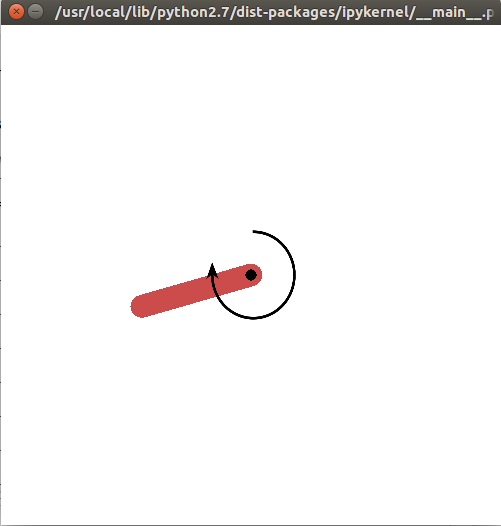

In [14]:
from IPython.display import Image
Image(filename='pendulum.png') 

In [15]:
##ddpg_pendulum1.py
'''
Created on Aug 18, 2016

@author: rbhat
'''
import numpy as np
import gym

from keras.layers import Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Convolution1D, MaxPooling1D, Convolution2D, MaxPooling2D

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input, merge, Embedding
from keras.optimizers import RMSprop

#from com.rl.continous.keras.ddpg import DDPGAgent
#from com.rl.continous.keras.memory import SequentialMemory
#from com.rl.continous.keras.Random1 import OrnsteinUhlenbeckProcess


#ENV_NAME = 'CarRacing-v0'
ENV_NAME = 'Pendulum-v0'
gym.undo_logger_setup()



# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
assert len(env.action_space.shape) == 1
nb_actions = env.action_space.shape[0]

# Next, we build a very simple model.
actor = Sequential()
actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
actor.add( Reshape( (3, 1) ) )
actor.add(Convolution1D(8, 1, border_mode='valid'))
actor.add(Flatten())
#actor.add(Dense(16))
#actor.add(Activation('relu'))
#actor.add(Dense(16))
#actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(nb_actions))
actor.add(Activation('linear'))
print(actor.summary())

action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = merge([action_input, flattened_observation], mode='concat')
x = Reshape((4, 1))(x)
x = Convolution1D(8, 1, border_mode='valid')(x)
x = Flatten()(x)
#x = Dense(32)(x)
#x = Activation('relu')(x)
#x = Dense(32)(x)
#x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(input=[action_input, observation_input], output=x)
print(critic.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
memory = SequentialMemory(limit=100000)
random_process = OrnsteinUhlenbeckProcess(theta=.15, mu=0., sigma=.3)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,
                  random_process=random_process, gamma=.99, target_model_update=1e-3,
                  delta_range=(-10., 10.))
agent.compile([RMSprop(lr=.001), RMSprop(lr=.001)], metrics=['mae'])

#agent.load_weights('ddpg_{}_weights.h5f'.format(ENV_NAME))

#env.reset()
#env.render()

#env.monitor.start('/home/rahul/S3Lab/Keras-RL/keras-rl/pendulumvids7')
# Okay, now it's time to learn something! We visualize the training here for show, but this
# slows down training quite a lot. You can always safely abort the training prematurely using
# Ctrl + C.
agent.fit(env, nb_steps=100000, visualize=True, verbose=1, nb_max_episode_steps=200) #True

env.monitor.close()

# After training is done, we save the final weights.
agent.save_weights('ddpg7_{}_weights.h5f'.format(ENV_NAME), overwrite=False)

# Finally, evaluate our algorithm for 5 episodes.
agent.test(env, nb_episodes=5, visualize=True, nb_max_episode_steps=200)



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
flatten_7 (Flatten)              (None, 3)             0           flatten_input_5[0][0]            
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 3, 1)          0           flatten_7[0][0]                  
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)  (None, 3, 8)          16          reshape_1[0][0]                  
____________________________________________________________________________________________________
flatten_8 (Flatten)              (None, 24)            0           convolution1d_1[0][0]            
___________________________________________________________________________________________

ArgumentError: argument 2: <type 'exceptions.TypeError'>: wrong type